In [ ]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [10]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

import scipy.stats as ss #for normal distribution

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SequentialSampler

import matplotlib.pyplot as plt


In [11]:
np.random.seed(42)

In [12]:
def get_angles(x):

    return np.array([x[0]*np.pi*2.5, x[1]*np.pi*2.5])#, x[2]*np.pi*2, x[3]*np.pi*2])

In [13]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [14]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [15]:
@qml.template
def statepreparation(a):
        qml.RX(a[0], wires=0)
        qml.RX(a[1], wires=1)
        qml.RX(a[0], wires=2)
        qml.RX(a[1], wires=3)

        qml.RY(np.pi / 4, wires=0)
        qml.RY(np.pi / 4, wires=1)
        qml.RY(np.pi / 4, wires=2)
        qml.RY(np.pi / 4, wires=3)

        qml.RZ(np.pi / 4, wires=0)
        qml.RZ(np.pi / 4, wires=1)
        qml.RZ(np.pi / 4, wires=2)
        qml.RZ(np.pi / 4, wires=3)

In [16]:
dev = qml.device("default.qubit", wires=4, shots=1000)

In [17]:
@qml.qnode(dev)
def circuit_19(weights, angles=None):
    
    ######################
    ##### CIRCUIT 19 #####
    ######################
    statepreparation(angles)

    for W in weights:
        qml.RX(W[0], wires=0)
        qml.RX(W[1], wires=1)
        qml.RX(W[2], wires=2)
        qml.RX(W[3], wires=3)

        qml.RZ(W[4], wires=0)
        qml.RZ(W[5], wires=1)
        qml.RZ(W[6], wires=2)
        qml.RZ(W[7], wires=3)

        qml.CRX(W[8], wires=[3, 0])
        qml.CRX(W[9], wires=[2, 3])
        qml.CRX(W[10], wires=[1, 2])
        qml.CRX(W[11], wires=[0, 1])

    
    return qml.probs(wires=[0, 1, 2, 3]) #qml.expval(qml.PauliZ(1) @ qml.PauliZ(0) @ qml.PauliZ(2))#

class c19:
    def __init__(self, layers):
        self.layers = layers
        print('Using Circuit 19 with ',layers,' layers')
        
    def get_numparams(self):
        #return self.layers * 12
        return 12
        
    def variational_classifier(self,var, angles=None):
        weights = var[0]
        bias = var[1]
        put = circuit_19(weights, angles=angles) + bias
        idx = np.argmax(put)
        
        if idx in [0,1,2,3,13,14,15,16]:
            out = -put[idx]
        else:
            out = put[idx]
        return out

    def cost(self, weights, features, labels):
        predictions = [self.variational_classifier(weights, angles=f) for f in features]
        return square_loss(labels, predictions)  

In [18]:
@qml.qnode(dev)
def circuit_01(weights, angles=None):
    
    ######################
    ##### CIRCUIT 01 #####
    ######################
    statepreparation(angles)

    for W in weights:
        qml.RX(W[0], wires=0)
        qml.RX(W[1], wires=1)
        qml.RX(W[2], wires=2)
        qml.RX(W[3], wires=3)

        qml.RZ(W[4], wires=0)
        qml.RZ(W[5], wires=1)
        qml.RZ(W[6], wires=2)
        qml.RZ(W[7], wires=3)

    return qml.probs(wires=[0, 1, 2, 3]) #qml.expval(qml.PauliZ(1) @ qml.PauliZ(0) @ qml.PauliZ(2))#

class c01:
    def __init__(self, layers):
        self.layers = layers
        print('Using Circuit 1 with ',layers,' layers')
        
    def get_numparams(self):
        return  8
        
    def variational_classifier(self,var, angles=None):
        weights = var[0]
        bias = var[1]
        put = circuit_01(weights, angles=angles) + bias
        idx = np.argmax(put)

        if idx in [0,1,2,3,13,14,15,16]:
            out = -put[idx]
        else:
            out = put[idx]
        return out

    def cost(self, weights, features, labels):
        predictions = [self.variational_classifier(weights, angles=f) for f in features]
        return square_loss(labels, predictions)   



In [19]:
def eins_a(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    cols = 1
    rows = 2
    centroids= np.zeros(shape=(cols*rows,2))
    start = [0.3,0.5]
    inc= 0.4
    Xvals, yvals = [], []
    count=0
    for c in range(0,cols):
        for r in range(0,rows):
            centroids[count][0] = start[0] + r * inc
            centroids[count][1] = start[1] 
            count +=1

    radius = 0.25

    for n in range(samples):

        t = 2*np.pi*np.random.random()
        u = np.random.random()+np.random.random()
        if u>1:
            r = 2-u 
        else: 
            r = u

        a = r*np.cos(t)*radius
        b = r*np.sin(t)*(radius+0.125)
        dot = np.random.randint(0, 2)
        
        if dot in [0,2,5,7,8,10,13,15]:
            yvals.append(0)
        else:
            yvals.append(1)

       
        x = centroids[dot][0]+a - 0.5
        y = centroids[dot][1]+b - 0.5
        
        Xvals.append([x, y])
        
    return np.array(Xvals), np.array(yvals)

In [20]:
def eins_b(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    centroids = [[0.4,0.2],[0.6,0.5],[0.4,0.8]]

    radius = 0.135
    Xvals, yvals = [], []
    for n in range(samples):  

        x = np.arange(-np.pi,np.pi,0.01)
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = 1.8) - ss.norm.cdf(xL, scale = 1.8)
        prob = prob / prob.sum() #normalize the probabilities so their sum is 1

        dot = np.random.randint(0, 3)
        if dot in [0,2]:
            yvals.append(0)
            t = np.random.choice(x, size = 1, p = prob)
        else:
            yvals.append(1)
            t = np.random.choice(x, size = 1, p = prob)+np.pi


        u = np.random.random()+np.random.random()
        if u>1:
            r = 2-u 
        else: 
            r = u

        a = r*np.cos(t)*(radius+0.15)
        b = r*np.sin(t)*radius

        x = centroids[dot][0]+a - 0.5
        y = centroids[dot][1]+b - 0.5

             
        Xvals.append([x[0], y[0]])
        

    
    return np.array(Xvals), np.array(yvals)

In [21]:
def eins_c(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    
    centroids = [[0.3,0.15],[0.7,0.383333],[0.3,0.623333],[0.7,0.85]]

    radius = 0.155

    Xvals, yvals = [], []


    for n in range(samples):  

        x = np.arange(-np.pi,np.pi,0.01)
        xU, xL = x + 0.5, x - 0.5 
        prob = ss.norm.cdf(xU, scale = 1.5) - ss.norm.cdf(xL, scale = 1.5)
        prob = prob / prob.sum() #normalize the probabilities so their sum is 1

        dot = np.random.randint(0, 4)
        if dot in [0,2]:
            yvals.append(0)
            t = np.random.choice(x, size = 1, p = prob)
        else:
            yvals.append(1)
            t = np.random.choice(x, size = 1, p = prob)+np.pi

        #t  ###Todo, das darf keine gleichverteilung sein.... biased für eine hälfte
        u = np.random.random()+np.random.random()
        if u>1:
            r = 2-u 
        else: 
            r = u

        a = r*np.cos(t)*(radius+0.15)
        b = r*np.sin(t)*radius

        x = centroids[dot][0]+a -0.5
        y = centroids[dot][1]+b -0.5
        
        Xvals.append([x[0], y[0]])
        
    return np.array(Xvals), np.array(yvals)        

In [68]:
def drei_a(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    
    Xvals, yvals = [], []
    
    for n in range(samples):
        x = np.random.uniform(0, 1)-0.5
        y = np.random.uniform(0, 1)-0.5
        
        if np.sqrt(x*x+y*y) <= 0.2:
            yvals.append(0)
        else:
            yvals.append(1)
            
        Xvals.append([x, y])
        
    return np.array(Xvals), np.array(yvals)

In [69]:
def drei_c(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    Xvals, yvals = [], []

    for n in range(samples):
        a = np.random.uniform(0, 1)
        b = np.random.uniform(0, 1)

        x=a-0.25
        y=b-0.25

        x1=a-0.75
        y1=b-0.75

        x2=a-0.25
        y2=b-0.75

        x3=a-0.75
        y3=b-0.25

        if np.sqrt(x*x+y*y) <= 0.15:
            yvals.append(0)

        elif np.sqrt(x1*x1+y1*y1) <= 0.15:   
            yvals.append(0)

        elif np.sqrt(x2*x2+y2*y2) <= 0.15:   
            yvals.append(0)

        elif np.sqrt(x3*x3+y3*y3) <= 0.15:   
            yvals.append(0)

        else:
            yvals.append(1)
            
        Xvals.append([a-0.5, b-0.5])
        
        
    return np.array(Xvals), np.array(yvals)

In [70]:
def drei_b(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    
    Xvals, yvals = [], []

    
    for n in range(samples):

        a = np.random.uniform(0, 1)
        b = np.random.uniform(0, 1)

        x=a-0.25
        y=b-0.25

        x1=a-0.75
        y1=b-0.75

        if np.sqrt(x*x+y*y) <= 0.15:
            yvals.append(0)


        elif np.sqrt(x1*x1+y1*y1) <= 0.15:   
            yvals.append(0)

        else:
            yvals.append(1)

        Xvals.append([a-0.5, b-0.5])
        
        
    return np.array(Xvals), np.array(yvals)

In [71]:
def zwei_a(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    centroids = [[0.3,0.7],[0.7,0.7],[0.3,0.3],[0.7,0.3]]

    radius = 0.15
    Xvals, yvals = [], []

    for n in range(samples):

        t = 2*np.pi*np.random.random()
        u = np.random.random()+np.random.random()
        if u>1:
            r = 2-u 
        else: 
            r = u

        a = r*np.cos(t)*radius
        b = r*np.sin(t)*radius

        dot = np.random.randint(0, len(centroids))

        if dot == 0 or dot == 3:
            yvals.append(0)
        else:
            yvals.append(1)


        x = centroids[dot][0]+a -0.5
        y = centroids[dot][1]+b -0.5

        Xvals.append([x, y])
        
    return np.array(Xvals), np.array(yvals)


In [72]:
def zwei_b(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    centroids = [[0.2,0.2],[0.5,0.2],[0.8,0.2],[0.2,0.5],[0.5,0.5],[0.8,0.5],[0.2,0.8],[0.5,0.8],[0.8,0.8]]

    radius = 0.12
    Xvals, yvals = [], []

    for n in range(samples):

        t = 2*np.pi*np.random.random()
        u = np.random.random()+np.random.random()
        if u>1:
            r = 2-u 
        else: 
            r = u

        a = r*np.cos(t)*radius
        b = r*np.sin(t)*radius
        dot = np.random.randint(0, len(centroids))


        if dot%2 == 0:
            yvals.append(0)
        else:
            yvals.append(1)

        x = centroids[dot][0]+a -0.5
        y = centroids[dot][1]+b -0.5

        Xvals.append([x, y])
        
    return np.array(Xvals), np.array(yvals)

In [73]:
def zwei_c(samples, center=[0.0, 0.0], radius=np.sqrt(2 / np.pi)):
    """
    Generates a dataset of points with 1/0 labels inside a given radius.

    Args:
        samples (int): number of samples to generate
        center (tuple): center of the circle
        radius (float: radius of the circle

    Returns:
        Xvals (array[tuple]): coordinates of points
        yvals (array[int]): classification labels
    """
    Xvals, yvals = [], []

    cols = 4
    rows = 4
    centroids = np.zeros(shape=(cols * rows, 2))
    start = [0.2, 0.2]
    inc = 0.2
    inp = []
    labelz = []
    count = 0
    for c in range(0, cols):
        for r in range(0, rows):
            centroids[count][0] = start[0] + r * inc
            centroids[count][1] = start[1] + c * inc
            count += 1

    radius = 0.08

    for n in range(samples):

        t = 2 * np.pi * np.random.random()
        u = np.random.random() + np.random.random()
        if u > 1:
            r = 2 - u
        else:
            r = u

        a = r * np.cos(t) * radius
        b = r * np.sin(t) * radius
        dot = np.random.randint(0, len(centroids))
        label = -1
        if dot in [0, 2, 5, 7, 8, 10, 13, 15]:
            yvals.append(0)

        else:
            yvals.append(1)

        x = centroids[dot][0] + a -0.5
        y = centroids[dot][1] + b -0.5

        Xvals.append([x, y])

    return np.array(Xvals), np.array(yvals)

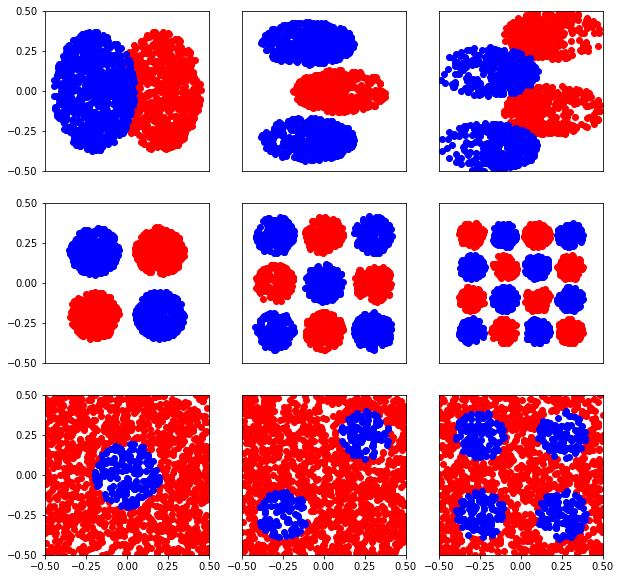

In [74]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

ds = [eins_a,eins_b,eins_c,zwei_a,zwei_b,zwei_c,drei_a,drei_b,drei_c]

for i, ax in enumerate(axs.flat):
    X,Y = ds[i](1500)
    Y= Y * 2 - np.ones(len(Y))
    ax.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="r", marker="o")
    ax.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="b", marker="o")
    
    
    custom_xlim = (-0.5, 0.5)
    custom_ylim = (-0.5, 0.5)
     # Setting the values for all axes.
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim,xticks=[],yticks=[])
    

    if i in [0,3,6]:
        plt.setp(ax,yticks=[-0.5,-0.25,0,0.25,0.5])
    if i in [6,7,8]:    
        plt.setp(ax,xticks=[-0.5,-0.25,0,0.25,0.5])
    

   

In [75]:
X,Y = drei_a(1500)
#X = data[:, 0:2]
print("First X sample (original)  :", X[0])


# pad the vectors to size 2^2 with constant values
padding = np.pi/3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

#Y = data[:, -1]
Y= Y * 2 - np.ones(len(Y))


First X sample (original)  : [0.40891295 0.2721414 ]
First X sample (padded)    : [0.40891295 0.2721414  1.04719755 0.        ]
First X sample (normalized): [0.35352498 0.23527937 0.90535281 0.        ]
First features sample      : [2.77657868 1.84787983]


These angles are our new features, which is why we have renamed X to
“features” above. Let’s plot the stages of preprocessing and play around
with the dimensions (dim1, dim2). Some of them still separate the
classes well, while others are less informative.

*Note: To run the following code you need the matplotlib library.*



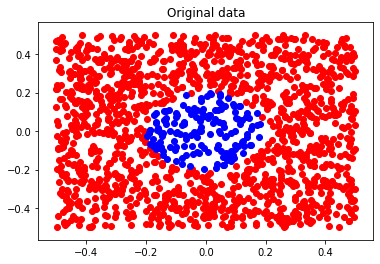

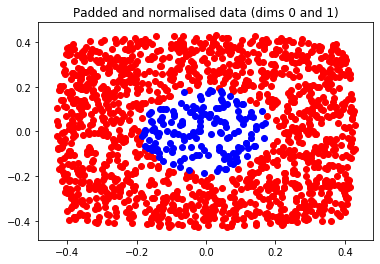

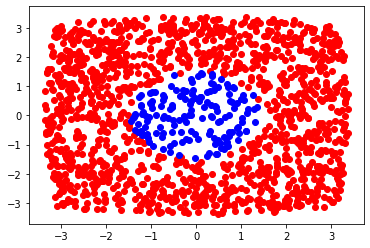

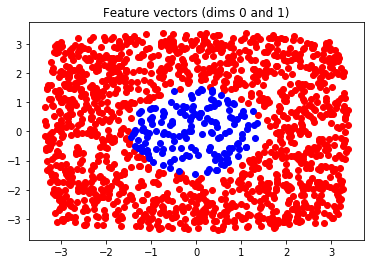

In [76]:

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="r", marker="o")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="b", marker="o")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="r", marker="o")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="b", marker="o")
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="r", marker="o")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="b", marker="o")

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="r", marker="o")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="b", marker="o")
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

This time we want to generalize from the data samples. To monitor the
generalization performance, the data is split into training and
validation set.



In [78]:
#np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Optimization
~~~~~~~~~~~~

First we initialize the variables.



In [79]:
num_qubits = 4
num_layers = 2

qc= c19(num_layers)
num_params = qc.get_numparams()

var_init = (0.01 * np.random.randn(num_layers, num_params), 0.01) #[[np.asarray([-0.25,-0.25,-0.25,-0.25,0.25,0.25,0.25,0.25])],0.01]#

Using Circuit 19 with  2  layers


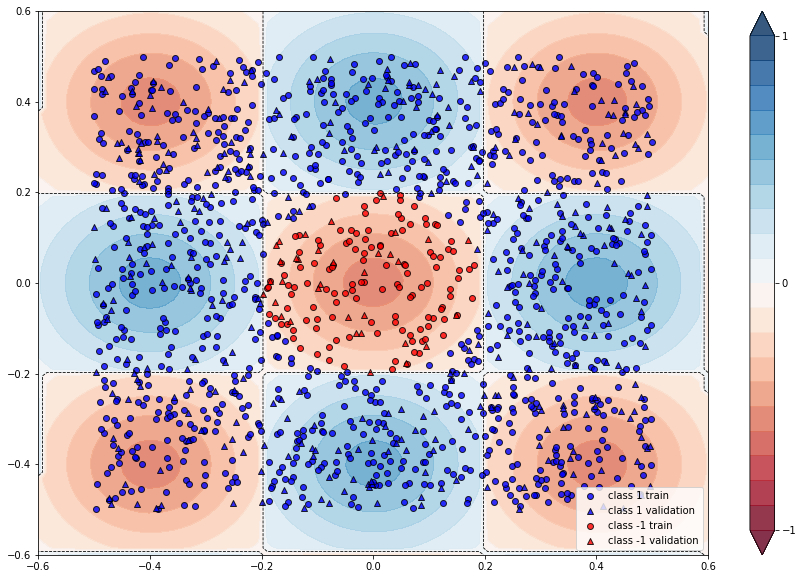

In [80]:
plt.subplots(1, 1, figsize=(15, 10))
var = var_init

cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-0.6, 0.6, 80), np.linspace(-0.6, 0.6, 80))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
#padding = 0.99* np.ones((len(X_grid), 1))
#X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
#normalization = np.sqrt(np.sum(X_grid ** 2, -1))
#X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles for state preparation are new features


predictions_grid = [qc.variational_classifier(var, angles=f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    alpha=0.8,
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    alpha=0.8,
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    alpha=0.8,
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    alpha=0.8,
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

Again we optimize the cost. This may take a little patience.



In [34]:
num_qubits = 4
num_layers = 2

qc= c19(num_layers)
num_params = qc.get_numparams()

best_val = (0.01 * np.random.randn(num_layers, num_params), 0.01)#[]
best_acc = 0.0

Using Circuit 19 with  2  layers


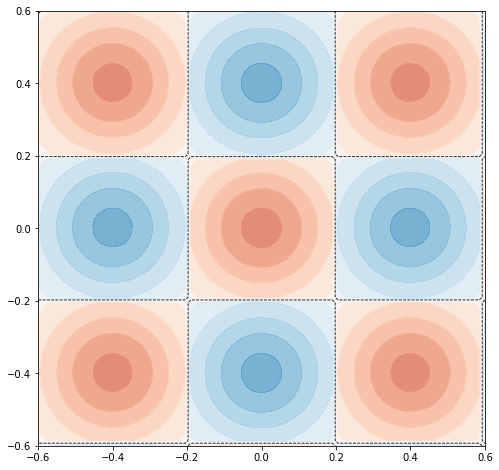

NEW BEST
Iter:     1 | Cost: 1.8947939 | Acc train: 0.5075556 | Acc validation: 0.5013333 | Best acc: 0.5075556


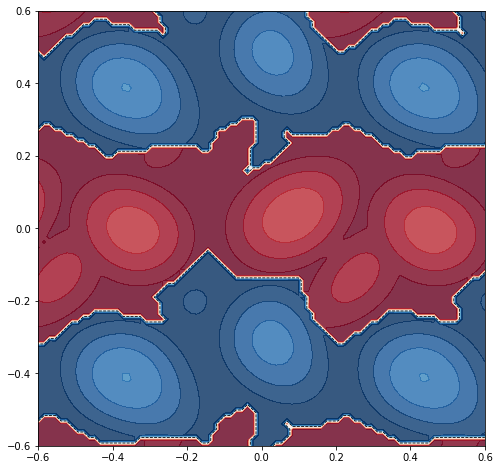

Iter:     2 | Cost: 4.0558743 | Acc train: 0.4328889 | Acc validation: 0.4186667 | Best acc: 0.5075556


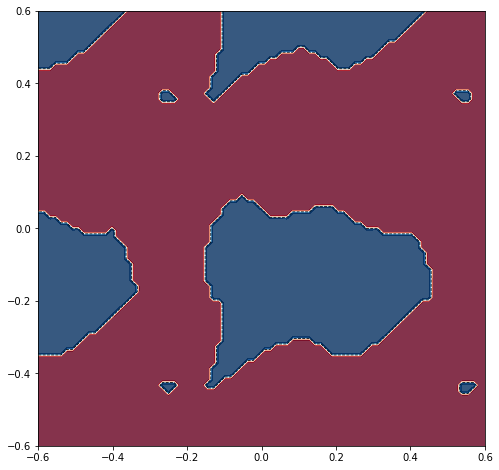

Iter:     3 | Cost: 4.1484988 | Acc train: 0.4444444 | Acc validation: 0.4506667 | Best acc: 0.5075556


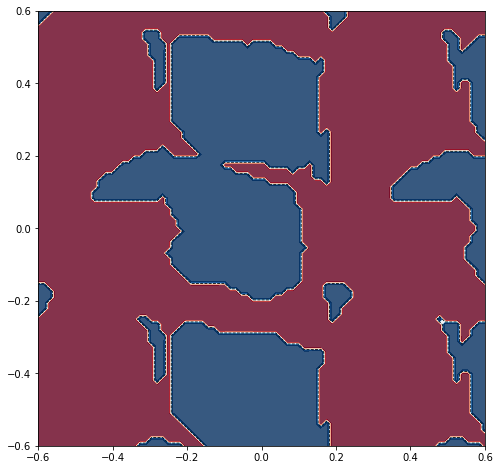

Iter:     4 | Cost: 3.3978323 | Acc train: 0.4044444 | Acc validation: 0.4000000 | Best acc: 0.5075556


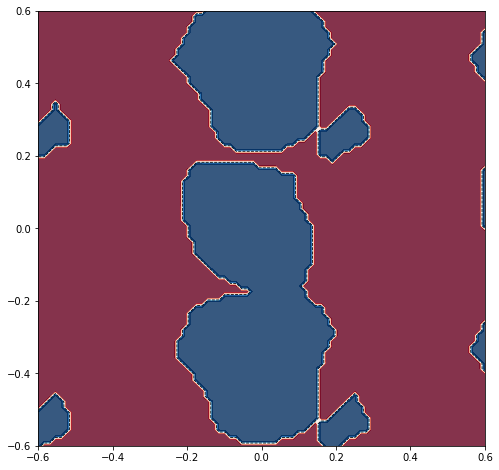

NEW BEST
Iter:     5 | Cost: 1.6868404 | Acc train: 0.5102222 | Acc validation: 0.5520000 | Best acc: 0.5102222


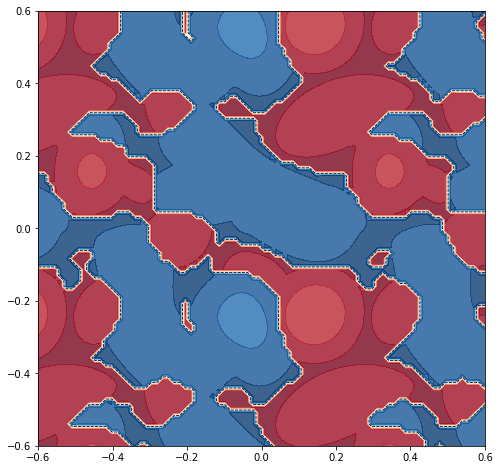

Iter:     6 | Cost: 1.0846274 | Acc train: 0.5102222 | Acc validation: 0.4613333 | Best acc: 0.5102222


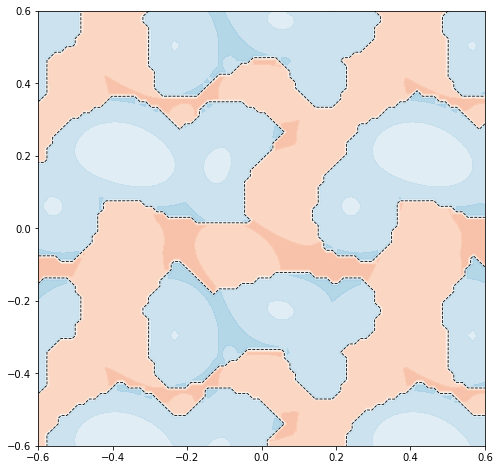

NEW BEST
Iter:     7 | Cost: 1.0977003 | Acc train: 0.5351111 | Acc validation: 0.5306667 | Best acc: 0.5351111


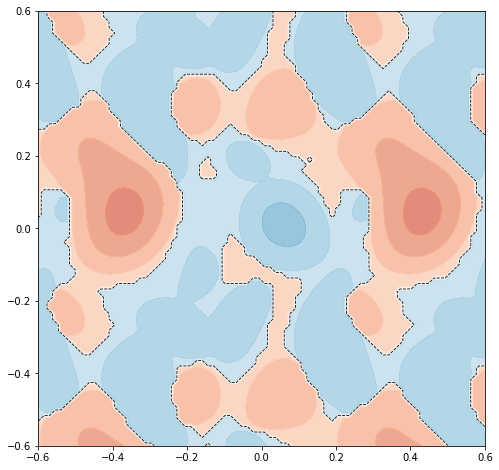

Iter:     8 | Cost: 1.9626231 | Acc train: 0.3964444 | Acc validation: 0.3840000 | Best acc: 0.5351111


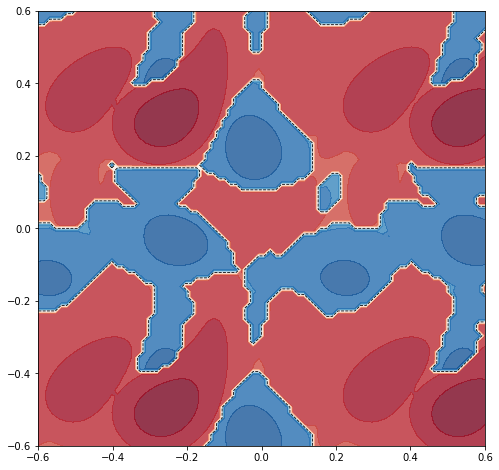

Iter:     9 | Cost: 2.0220295 | Acc train: 0.5173333 | Acc validation: 0.4666667 | Best acc: 0.5351111


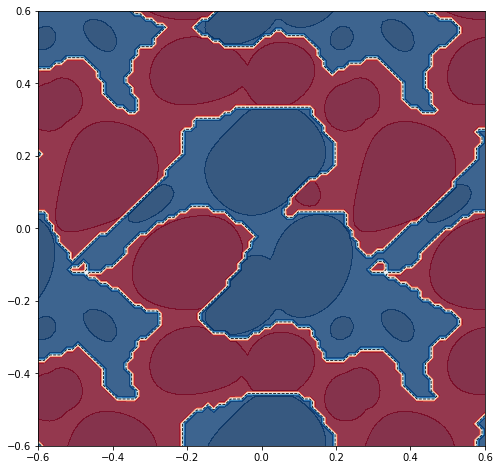

NEW BEST
Iter:    10 | Cost: 1.8562345 | Acc train: 0.5893333 | Acc validation: 0.5386667 | Best acc: 0.5893333


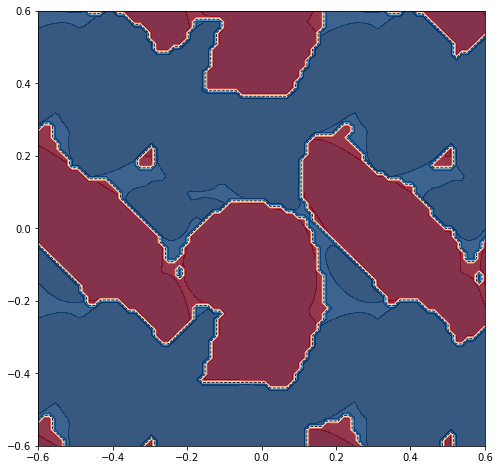

NEW BEST
Iter:    11 | Cost: 1.5471689 | Acc train: 0.5964444 | Acc validation: 0.5493333 | Best acc: 0.5964444


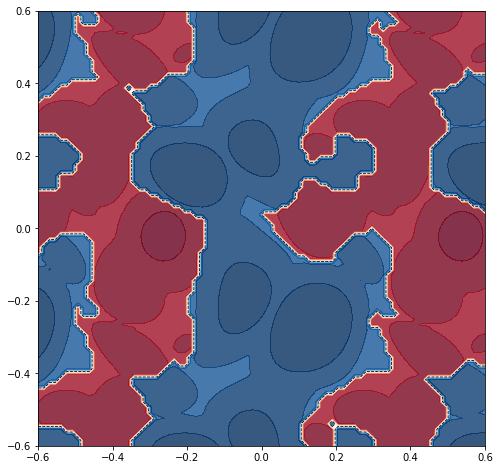

Iter:    12 | Cost: 1.5412954 | Acc train: 0.5066667 | Acc validation: 0.4773333 | Best acc: 0.5964444


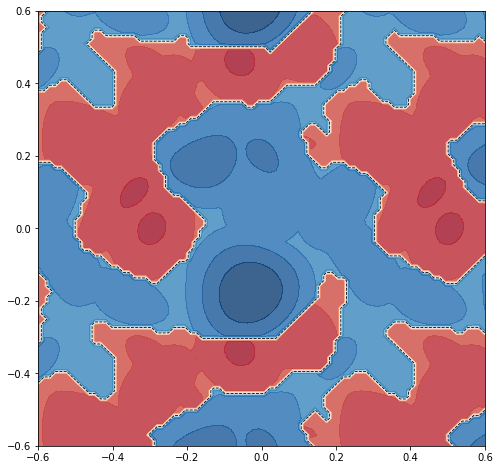

Iter:    13 | Cost: 1.1540143 | Acc train: 0.5128889 | Acc validation: 0.5120000 | Best acc: 0.5964444


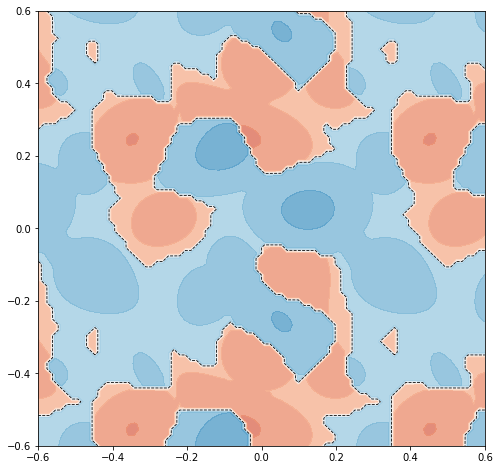

Iter:    14 | Cost: 1.0494705 | Acc train: 0.4373333 | Acc validation: 0.4373333 | Best acc: 0.5964444


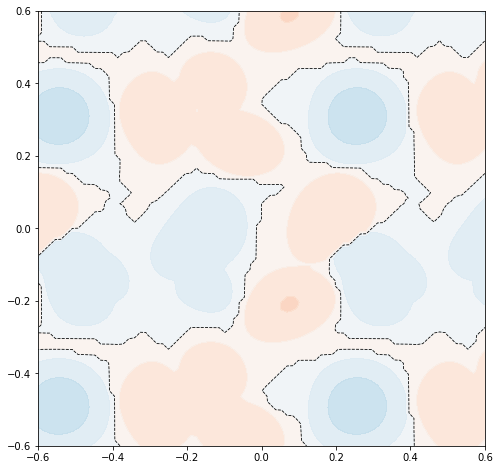

Iter:    15 | Cost: 1.0862407 | Acc train: 0.4044444 | Acc validation: 0.3706667 | Best acc: 0.5964444


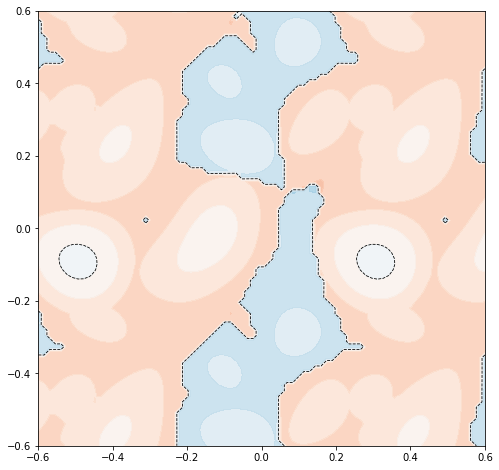

Iter:    16 | Cost: 1.3874189 | Acc train: 0.3342222 | Acc validation: 0.3360000 | Best acc: 0.5964444


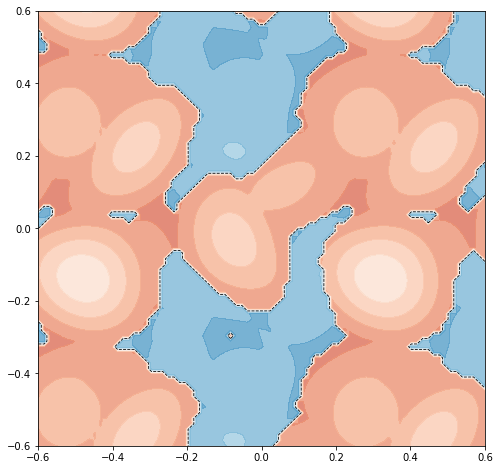

Iter:    17 | Cost: 1.4974994 | Acc train: 0.3591111 | Acc validation: 0.3466667 | Best acc: 0.5964444


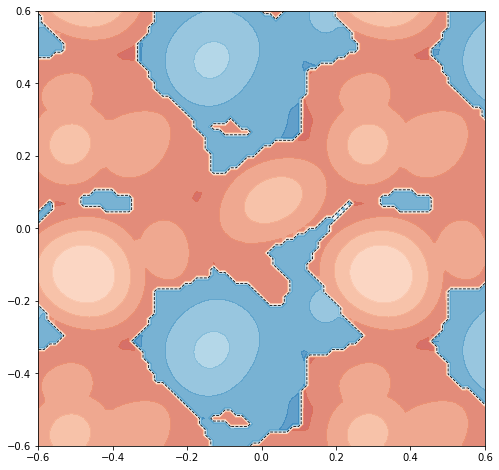

Iter:    18 | Cost: 1.4366458 | Acc train: 0.3235556 | Acc validation: 0.3546667 | Best acc: 0.5964444


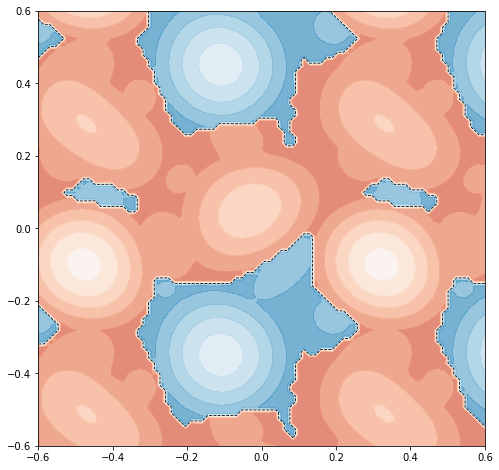

Iter:    19 | Cost: 1.2027196 | Acc train: 0.3635556 | Acc validation: 0.3706667 | Best acc: 0.5964444


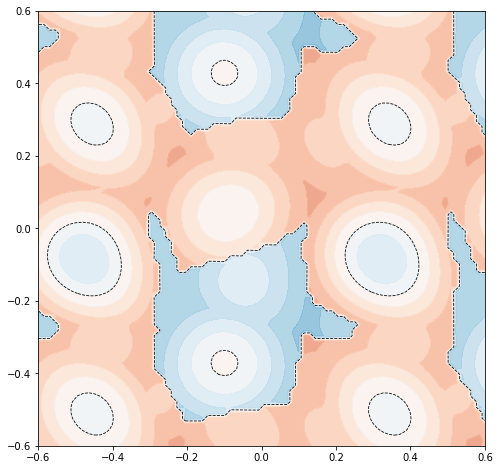

Iter:    20 | Cost: 0.9520225 | Acc train: 0.5964444 | Acc validation: 0.5413333 | Best acc: 0.5964444


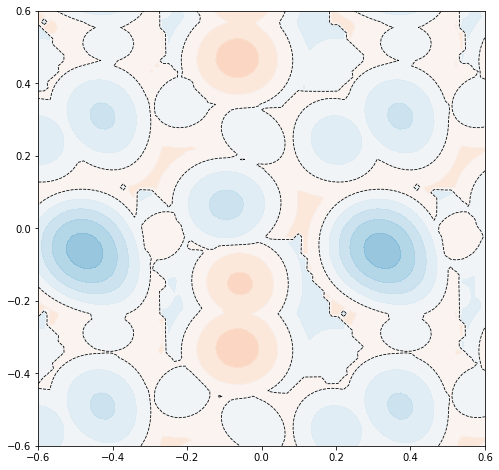

NEW BEST
Iter:    21 | Cost: 0.8357422 | Acc train: 0.6862222 | Acc validation: 0.6800000 | Best acc: 0.6862222


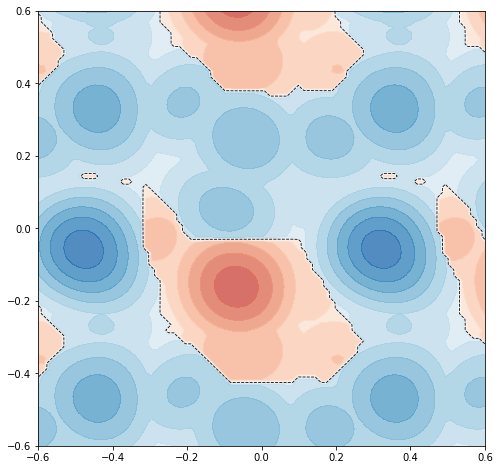

NEW BEST
Iter:    22 | Cost: 0.8106409 | Acc train: 0.7208889 | Acc validation: 0.7173333 | Best acc: 0.7208889


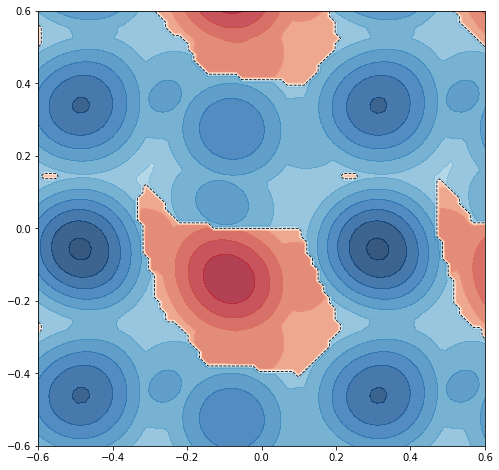

Iter:    23 | Cost: 0.8930929 | Acc train: 0.7191111 | Acc validation: 0.7280000 | Best acc: 0.7208889


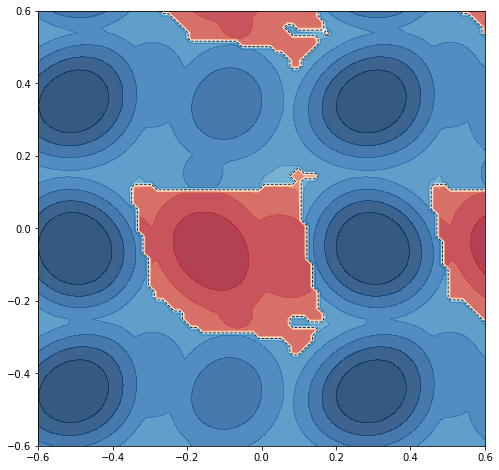

Iter:    24 | Cost: 1.1085205 | Acc train: 0.6933333 | Acc validation: 0.6533333 | Best acc: 0.7208889


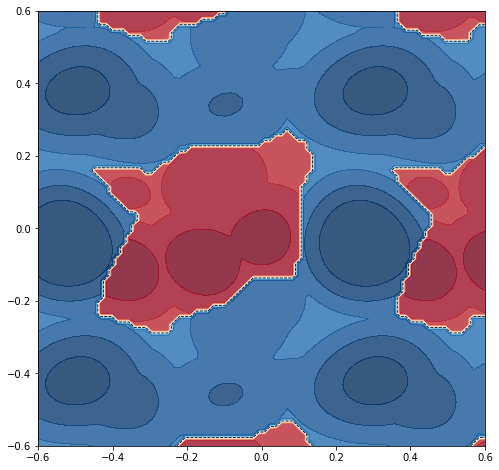

Iter:    25 | Cost: 1.3421031 | Acc train: 0.6293333 | Acc validation: 0.5840000 | Best acc: 0.7208889


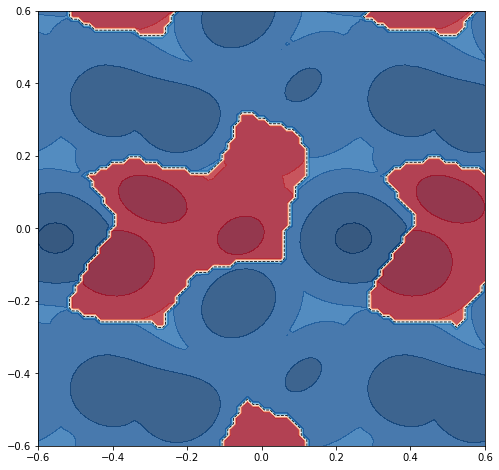

Iter:    26 | Cost: 1.0423398 | Acc train: 0.6684444 | Acc validation: 0.6826667 | Best acc: 0.7208889


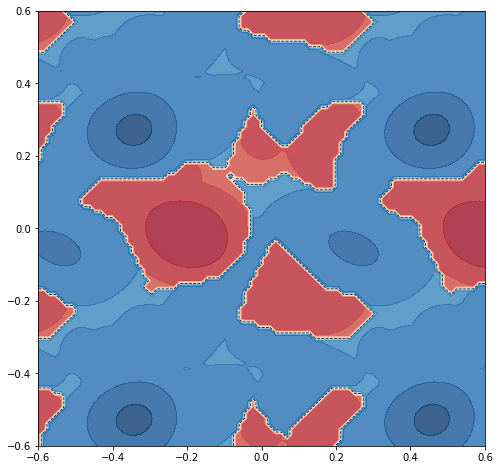

Iter:    27 | Cost: 1.0796177 | Acc train: 0.5982222 | Acc validation: 0.5813333 | Best acc: 0.7208889


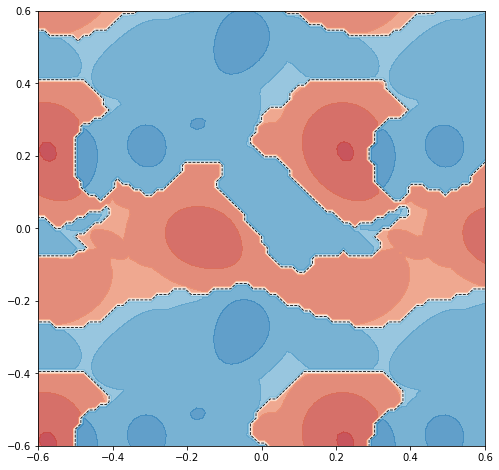

NEW BEST
Iter:    28 | Cost: 0.7888917 | Acc train: 0.7431111 | Acc validation: 0.7520000 | Best acc: 0.7431111


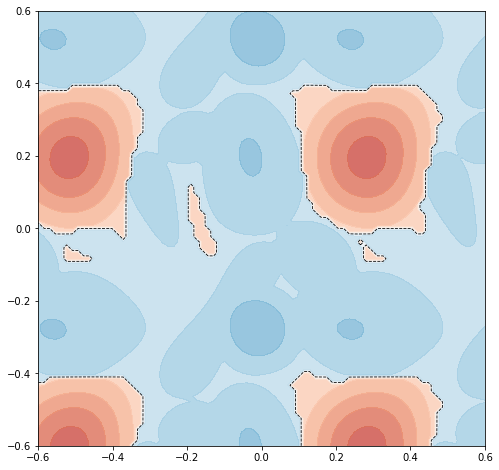

Iter:    29 | Cost: 0.8406842 | Acc train: 0.7164444 | Acc validation: 0.7306667 | Best acc: 0.7431111


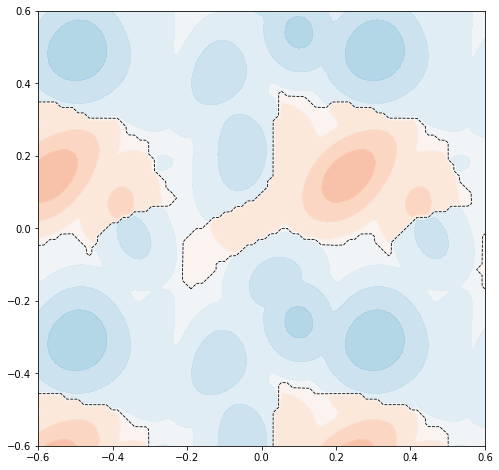

Iter:    30 | Cost: 0.9382258 | Acc train: 0.6488889 | Acc validation: 0.6373333 | Best acc: 0.7431111


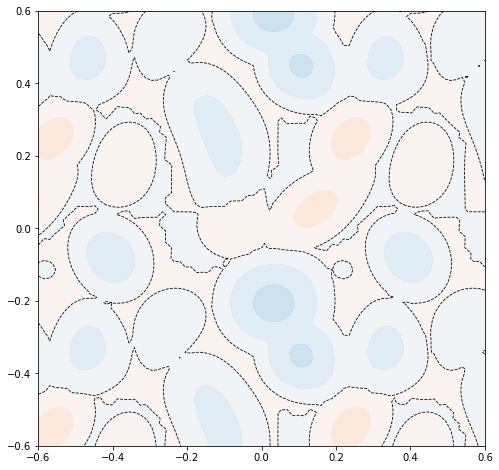

Iter:    31 | Cost: 0.9565173 | Acc train: 0.6240000 | Acc validation: 0.6400000 | Best acc: 0.7431111


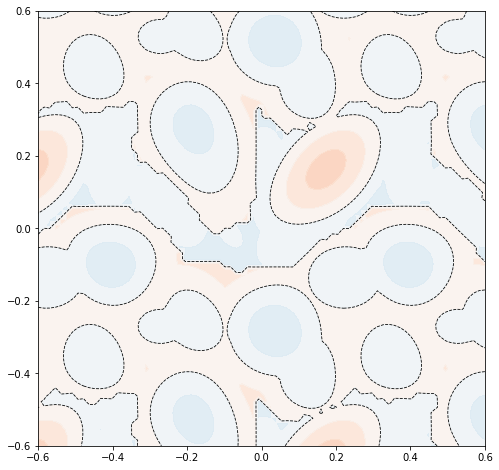

Iter:    32 | Cost: 0.9324004 | Acc train: 0.6613333 | Acc validation: 0.6480000 | Best acc: 0.7431111


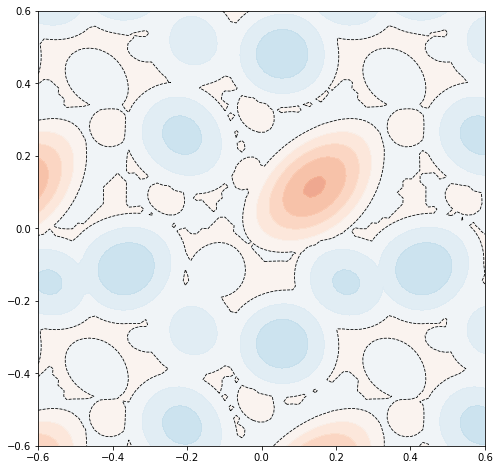

NEW BEST
Iter:    33 | Cost: 0.7707093 | Acc train: 0.8000000 | Acc validation: 0.7973333 | Best acc: 0.8000000


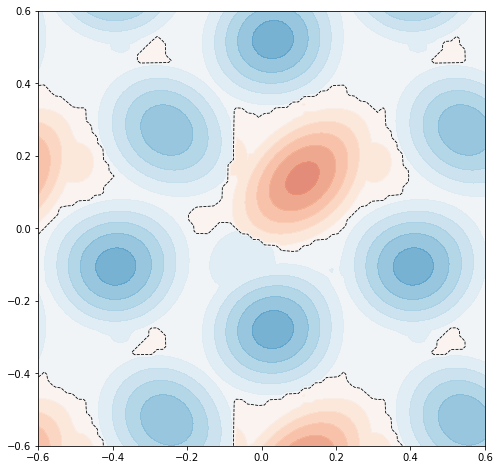

Iter:    34 | Cost: 0.8101295 | Acc train: 0.6808889 | Acc validation: 0.7253333 | Best acc: 0.8000000


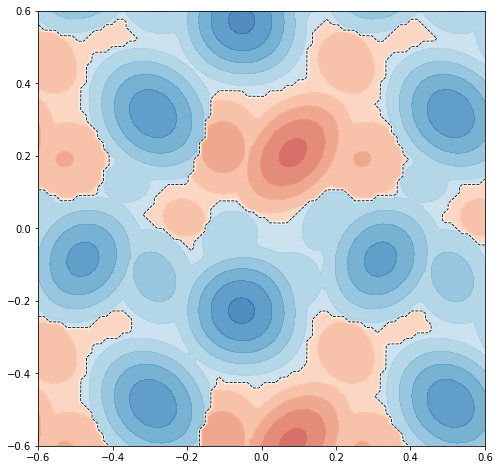

Iter:    35 | Cost: 0.6651485 | Acc train: 0.7688889 | Acc validation: 0.7786667 | Best acc: 0.8000000


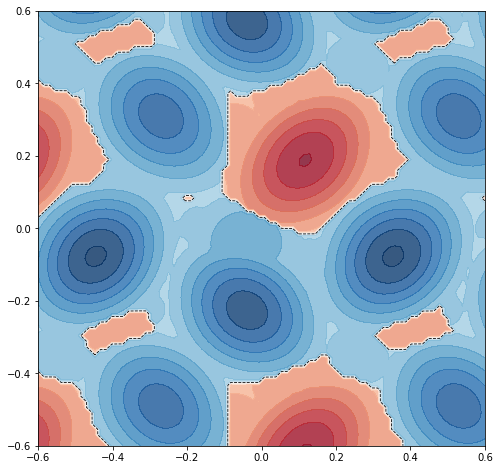

Iter:    36 | Cost: 0.8910714 | Acc train: 0.6951111 | Acc validation: 0.6826667 | Best acc: 0.8000000


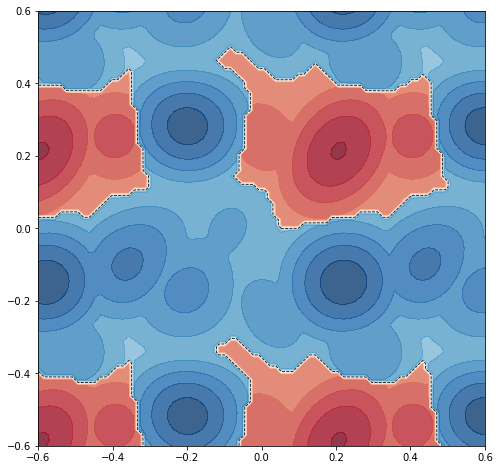

Iter:    37 | Cost: 1.1178509 | Acc train: 0.6355556 | Acc validation: 0.6266667 | Best acc: 0.8000000


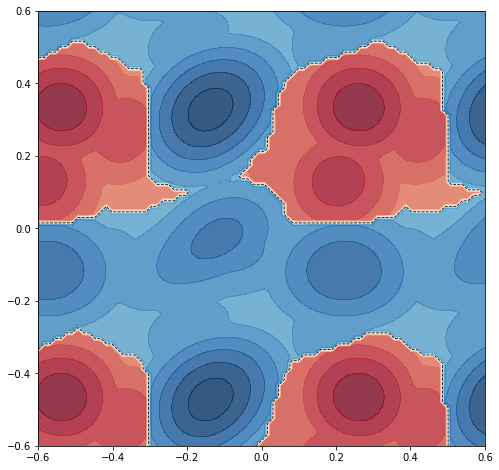

Iter:    38 | Cost: 1.0833409 | Acc train: 0.6391111 | Acc validation: 0.6293333 | Best acc: 0.8000000


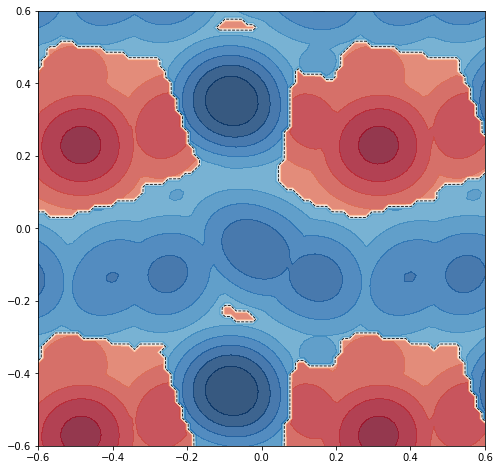

Iter:    39 | Cost: 0.8903655 | Acc train: 0.6746667 | Acc validation: 0.6800000 | Best acc: 0.8000000


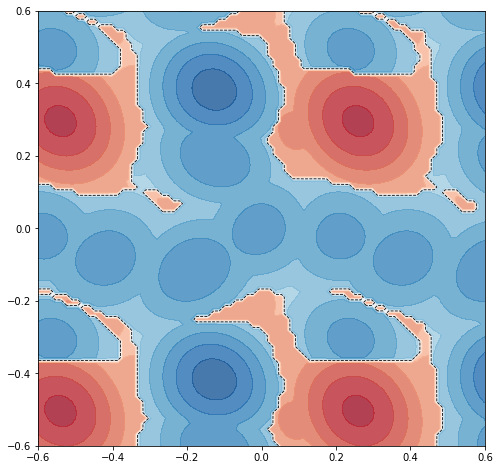

Iter:    40 | Cost: 0.9823133 | Acc train: 0.5866667 | Acc validation: 0.6026667 | Best acc: 0.8000000


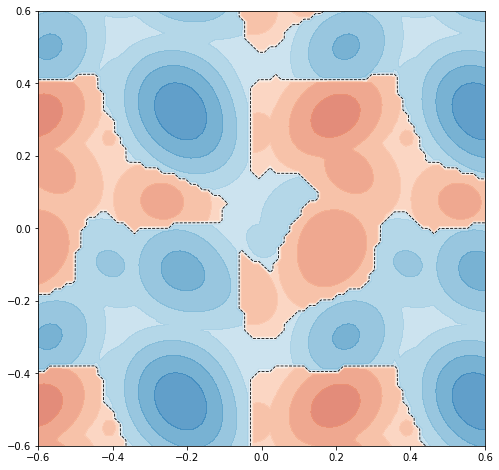

Iter:    41 | Cost: 0.9139436 | Acc train: 0.6062222 | Acc validation: 0.6186667 | Best acc: 0.8000000


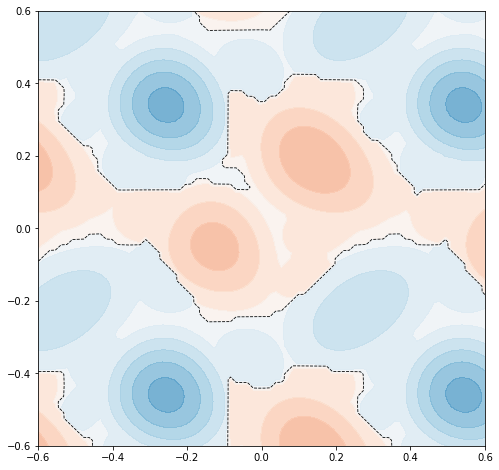

Iter:    42 | Cost: 0.9518010 | Acc train: 0.6071111 | Acc validation: 0.6586667 | Best acc: 0.8000000


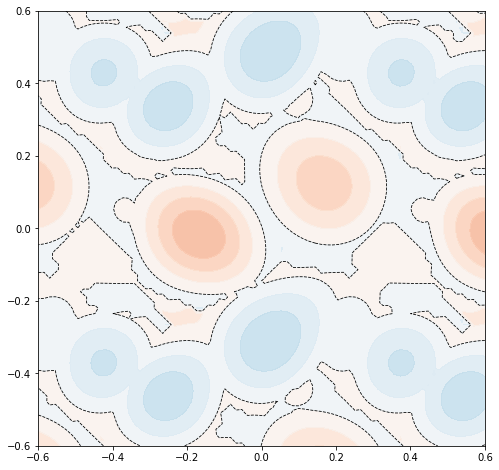

Iter:    43 | Cost: 0.9823327 | Acc train: 0.5831111 | Acc validation: 0.5546667 | Best acc: 0.8000000


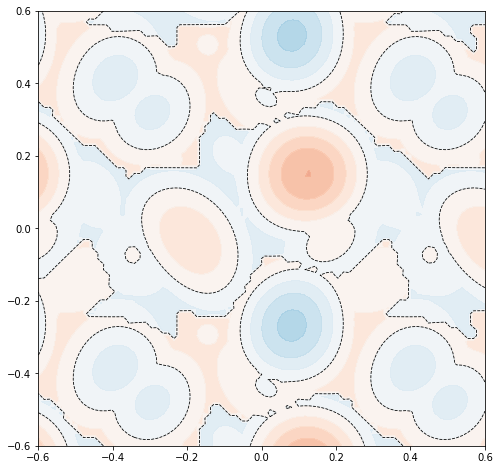

Iter:    44 | Cost: 1.0248511 | Acc train: 0.4471111 | Acc validation: 0.4400000 | Best acc: 0.8000000


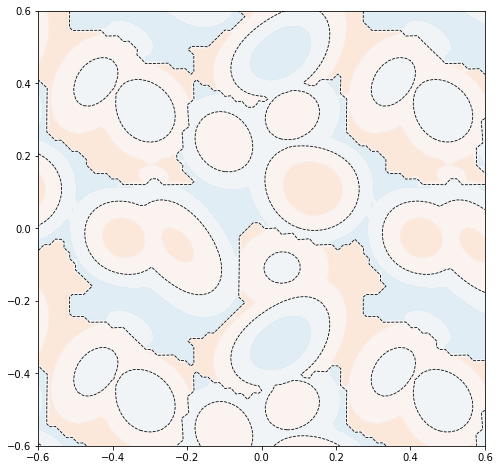

Iter:    45 | Cost: 0.9905304 | Acc train: 0.5111111 | Acc validation: 0.5466667 | Best acc: 0.8000000


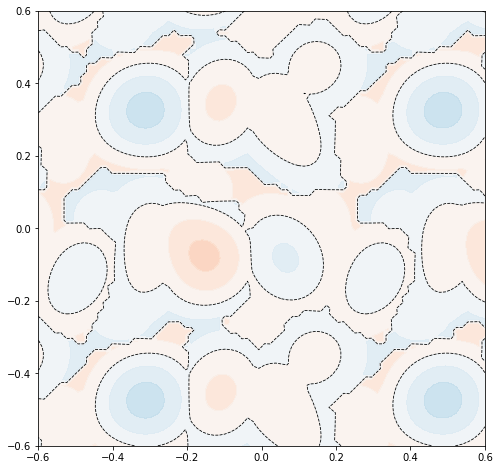

Iter:    46 | Cost: 0.9049544 | Acc train: 0.6560000 | Acc validation: 0.6320000 | Best acc: 0.8000000


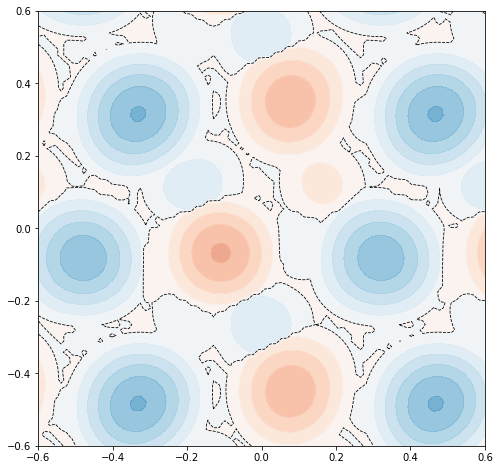

Iter:    47 | Cost: 0.9580898 | Acc train: 0.6382222 | Acc validation: 0.6640000 | Best acc: 0.8000000


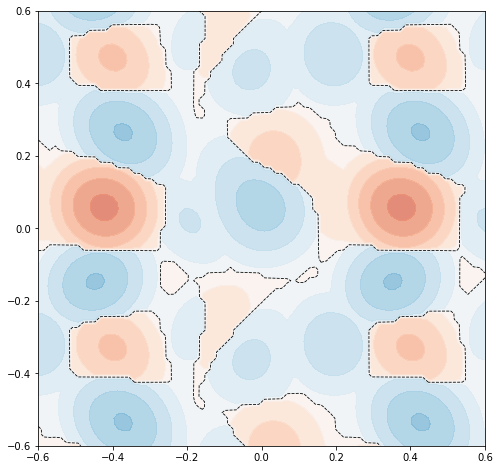

Iter:    48 | Cost: 0.9581413 | Acc train: 0.6497778 | Acc validation: 0.6320000 | Best acc: 0.8000000


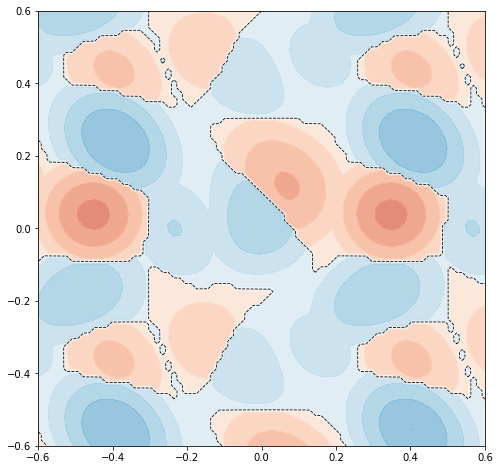

Iter:    49 | Cost: 0.9543180 | Acc train: 0.6382222 | Acc validation: 0.6186667 | Best acc: 0.8000000


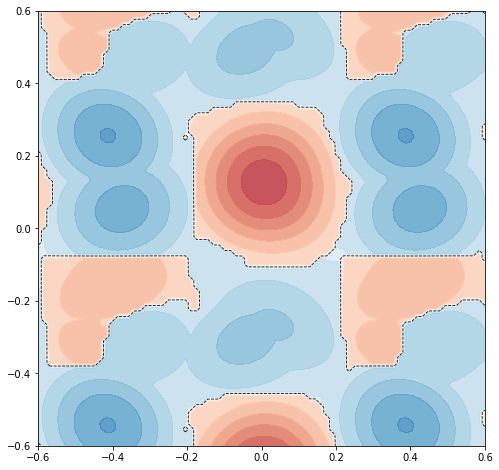

Iter:    50 | Cost: 0.8946467 | Acc train: 0.6871111 | Acc validation: 0.6693333 | Best acc: 0.8000000


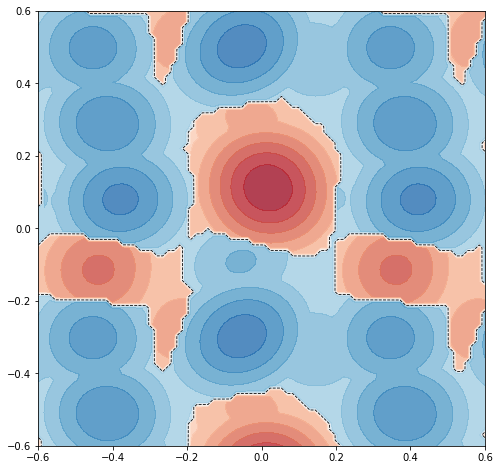

NEW BEST
Iter:    51 | Cost: 0.6242358 | Acc train: 0.8160000 | Acc validation: 0.7573333 | Best acc: 0.8160000


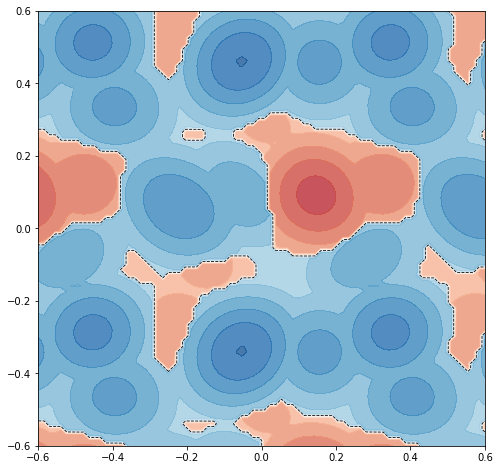

Iter:    52 | Cost: 0.6358863 | Acc train: 0.7937778 | Acc validation: 0.7840000 | Best acc: 0.8160000


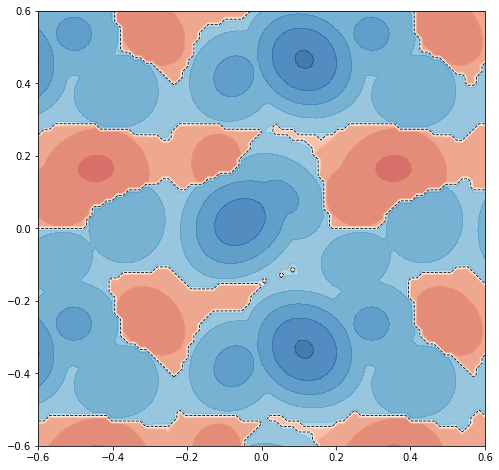

Iter:    53 | Cost: 0.6938607 | Acc train: 0.7617778 | Acc validation: 0.7680000 | Best acc: 0.8160000


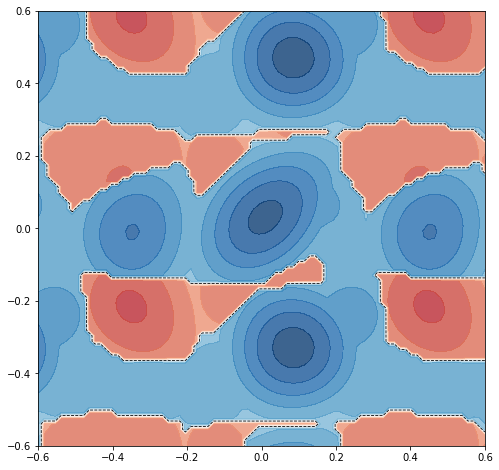

Iter:    54 | Cost: 0.5872859 | Acc train: 0.8142222 | Acc validation: 0.7946667 | Best acc: 0.8160000


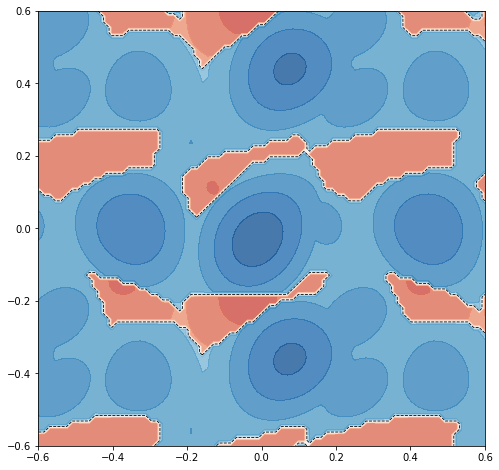

Iter:    55 | Cost: 0.5635861 | Acc train: 0.8160000 | Acc validation: 0.8266667 | Best acc: 0.8160000


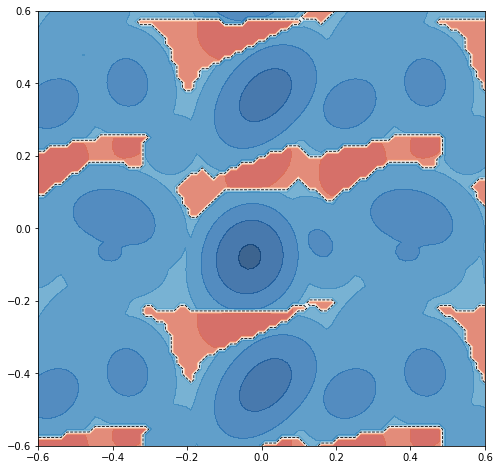

NEW BEST
Iter:    56 | Cost: 0.4644207 | Acc train: 0.8595556 | Acc validation: 0.8506667 | Best acc: 0.8595556


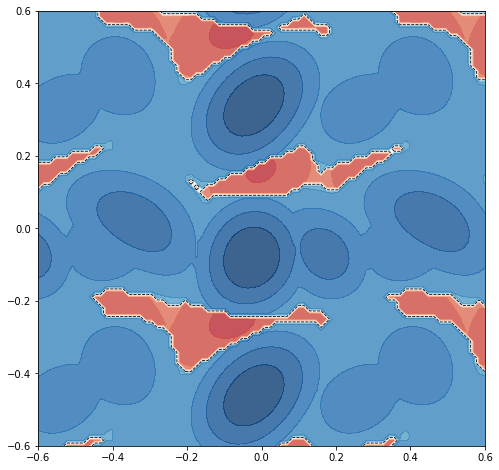

Iter:    57 | Cost: 0.4922340 | Acc train: 0.8453333 | Acc validation: 0.8506667 | Best acc: 0.8595556


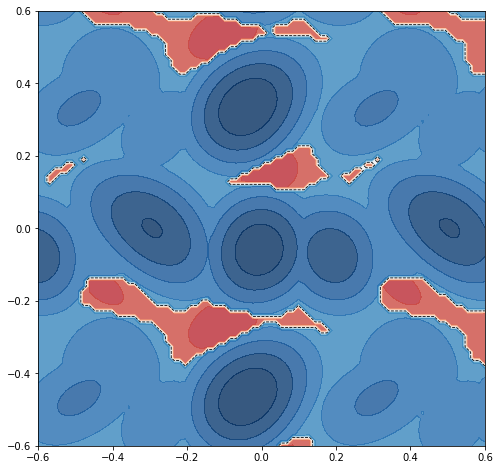

NEW BEST
Iter:    58 | Cost: 0.4530575 | Acc train: 0.8604444 | Acc validation: 0.8560000 | Best acc: 0.8604444


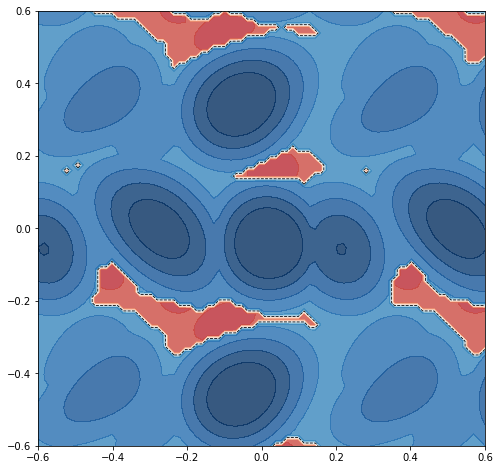

NEW BEST
Iter:    59 | Cost: 0.4344889 | Acc train: 0.8666667 | Acc validation: 0.8506667 | Best acc: 0.8666667


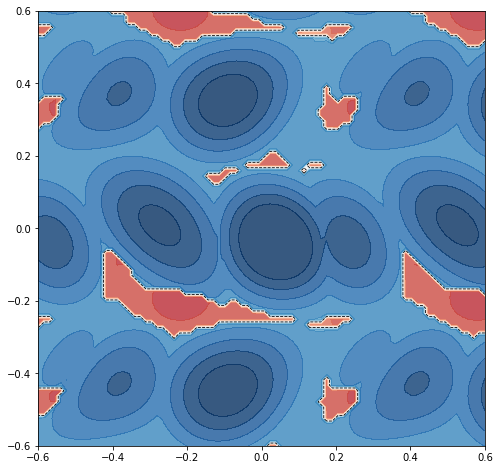

Iter:    60 | Cost: 0.4455942 | Acc train: 0.8604444 | Acc validation: 0.8506667 | Best acc: 0.8666667


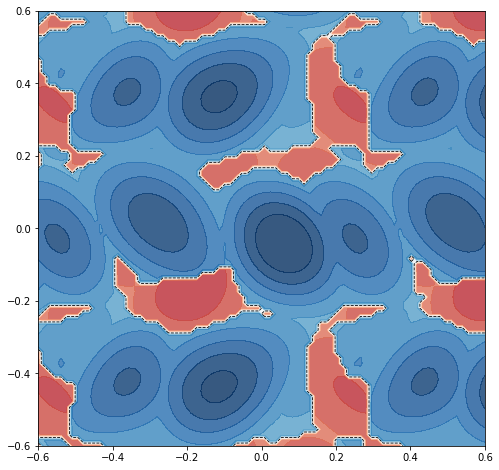

Iter:     1 | Cost: 0.8646704 | Acc train: 0.7457778 | Acc validation: 0.7520000 | Best acc: 0.8666667


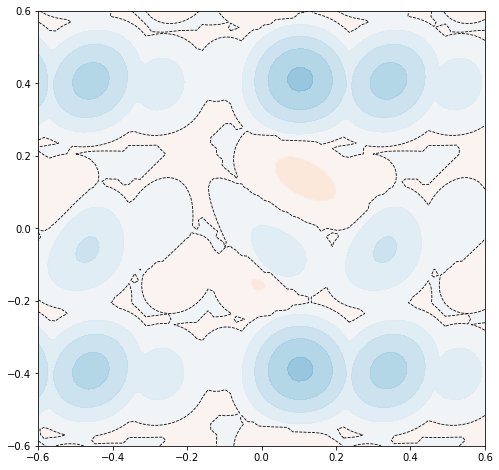

Iter:     2 | Cost: 0.7738776 | Acc train: 0.8097778 | Acc validation: 0.8053333 | Best acc: 0.8666667


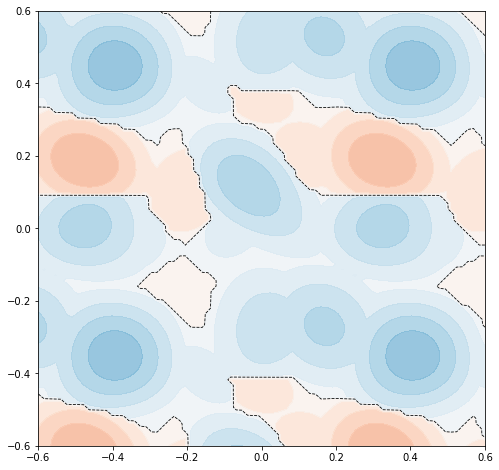

Iter:     3 | Cost: 0.9940152 | Acc train: 0.6435556 | Acc validation: 0.6240000 | Best acc: 0.8666667


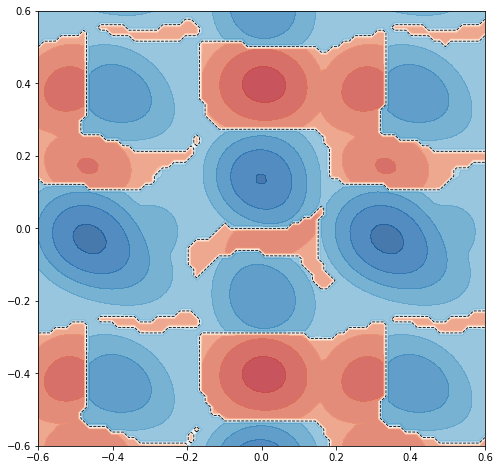

Iter:     4 | Cost: 0.8122120 | Acc train: 0.7333333 | Acc validation: 0.7066667 | Best acc: 0.8666667


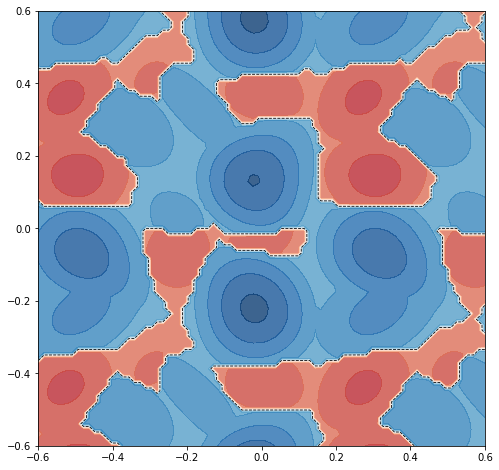

In [ ]:
from pennylane.optimize import AdamOptimizer
#opt = NesterovMomentumOptimizer(0.01)
learning_rate = [4,2,1,0.5,0.25,0.1]
opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)
rNUMBER = 0
losslist = []

batch_size = 256#with: 256 -- 0.9511111

# train the variational classifier
var = best_val#var_init

for lr in learning_rate:
    opt = AdamOptimizer(lr, beta1=0.9, beta2=0.999)

    for it in range(60):
        
        
        #### Plot all routine ###########################
        
         # plot decision regions
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

        cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
        plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
        #plt.colorbar(cnt, ticks=[-1, 0, 1])
        plt.show()

        fig.savefig(str(rNUMBER)+'.png')
        rNUMBER = rNUMBER+1   
        
        ###############################################
        

        # Update the weights by one optimizer step
        batch_index = np.random.randint(0, num_train, (batch_size,))
        #feats_train_batch = feats_train[batch_index]
        feats_train_batch = feats_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        var = opt.step(lambda v: qc.cost(v, feats_train_batch, Y_train_batch), var)

        # Compute predictions on train and validation set
        predictions_train = [np.sign(qc.variational_classifier(var, angles=f)) for f in feats_train]
        predictions_val = [np.sign(qc.variational_classifier(var, angles=f)) for f in feats_val]

        # Compute accuracy on train and validation set
        acc_train = accuracy(Y_train, predictions_train)
        acc_val = accuracy(Y_val, predictions_val)

        if acc_train > best_acc:
            print("NEW BEST")
            best_val = var
            best_acc = acc_train
            
        predictions_grid = [qc.variational_classifier(var, angles=f) for f in features_grid]
        Z = np.reshape(predictions_grid, xx.shape)

        loss = qc.cost(var, features, Y)
        losslist.append(loss)

        print(
            "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} | Best acc: {:0.7f}"
            "".format(it + 1, loss, acc_train, acc_val, best_acc)
        )


print(best_val)

Text(0, 0.5, 'Loss')

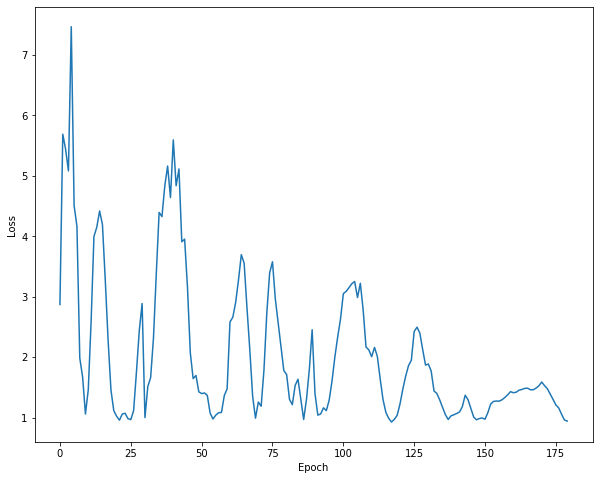

In [28]:
plt.subplots(1, 1, figsize=(10, 8))

plt.plot(losslist)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
[array([[  9.71582976,   4.24793181,   0.7881152 , -28.02838908,
          5.18898025,   3.70758127,  -7.27133639,  33.89925298,
          4.70763036,  -5.98564978, -13.73800122,   3.87705619],
       [  2.11752571,   1.50478352,  -8.91475487,   0.84420995,
          3.56879712,  19.1116578 ,   1.49376633,  23.74953409,
          3.57118874, -16.94343297,   6.01393273,  13.44750101]]), 0.06028883296470648]

In [ ]:
C19 1l 2c: [array([[  1.26219522,  -8.74546759,  -2.56776987,  -6.76057289,
         -2.20030447, -11.87491435, -19.85447727, -20.31629204,
        -12.39192614,   9.95819366,  -7.05129028,  13.83186647]]), -0.2331519784656126]

In [33]:
all_vals =[]

In [34]:
print('C19 2l 1a') #- 95.1111

#[array([[-2.07874496e+00, -9.88292797e+00,  7.54775427e+00,
#        -1.40284845e+01,  1.25103735e+01, -8.23842789e+00,
#        -2.68590104e+01,  3.19111420e+01, -9.44007689e+00,
#         1.95247770e+01, -4.98738255e-01,  2.26783070e+00,
#        -2.08144872e-03, -8.21492169e-03,  1.40578679e-02,
#        -1.13316186e-02,  1.57335525e-02, -5.39509899e-04,
#         5.89225787e-03,  2.67765546e-03,  5.06577266e-03,
#         1.05103469e-02, -1.27500293e-02,  8.15202614e-03],
#       [ 2.22620586e-02,  5.30433767e+00,  8.62671691e+00,
#        -1.74111712e+01, -9.20512936e+00, -1.73019739e+01,
#         6.92647750e+00, -5.41422471e+01, -8.43172493e+00,
#         1.83986128e+01,  6.02587124e+00, -3.87408024e-01,
#        -2.92841539e-03,  2.12479768e-03, -1.61927156e-02,
#        -2.48254757e-03,  3.86102685e-03, -3.59969871e-03,
#        -9.77795911e-03, -6.83040435e-03, -1.66698849e-02,
#        -2.47180022e-03, -1.19482754e-02, -8.43099342e-03]]), 0.5579496113627336]

all_vals.append([[[-7.14223854e-03, -4.40235100e+00, -1.10253857e+00,
        -7.70107121e+00, -2.90587270e+01,  2.75558215e+01,
        -3.24905575e+01, -1.15731787e+01, -2.03673596e+01,
        -1.59883221e-01, -1.21592538e+01, -1.02639537e+00],
       [ 1.66754817e+00,  6.29325142e+00,  8.49477328e+00,
        -1.28794428e+01, -2.80957511e+01,  2.82363739e+00,
         9.39886840e-01, -1.92578942e+01,  2.04022789e+00,
        -8.80299333e+00, -3.10362963e+00,  2.19759672e-01]], 0.46548857183493486])

C19 2l 1a


C19 2l 1b


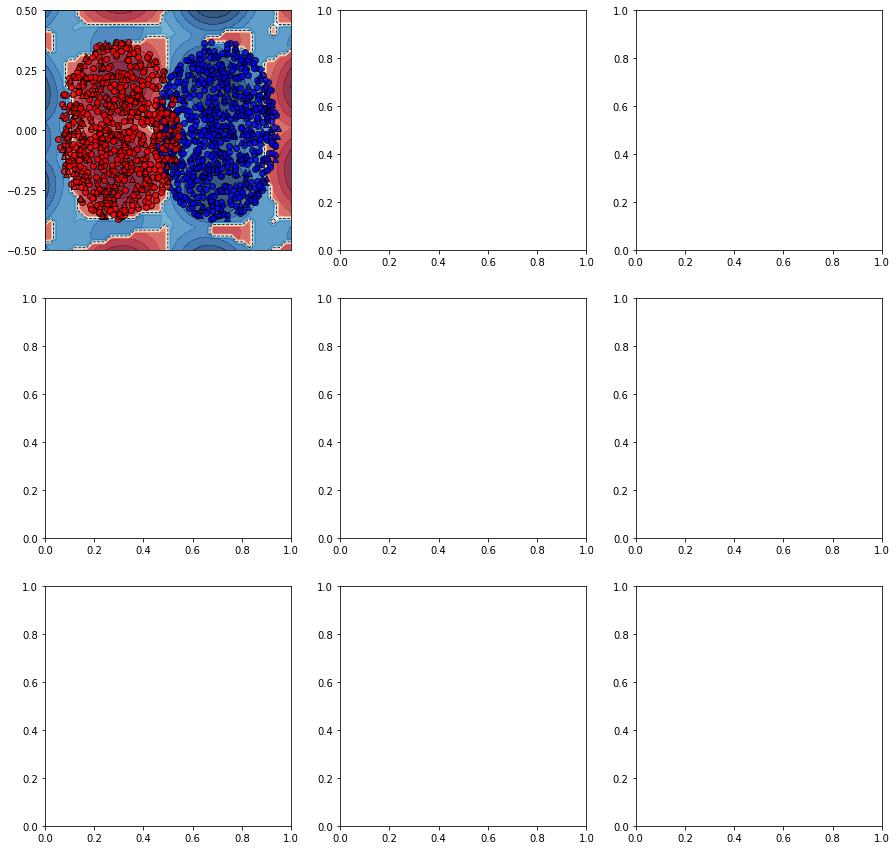

In [39]:
print('C19 2l 1b') #- 0.9991111

all_vals.append([[[  5.82047611, -15.33659282, -10.007703  , -11.89343312,
        -19.98655061, -10.90450545,  -3.12823891,  18.87085985,
        -12.8270699 ,  12.44909055,  -6.15556241,  -3.62628762],
       [-13.26741085,   7.20992478, -13.23020321, -13.04785704,
         20.60691182, -10.38965207,  18.27889623,  10.50491735,
        -11.96764469, -12.11273265,  -5.47560058, -11.84164108]], 0.7630038745429565])


In [40]:
print('C19 2l 1c') #- 0.98

all_vals.append([[[ -0.93971767,  -5.28995982,  -1.18516081, -14.07194826,
         14.65268547, -22.91611752, -29.35103761, -27.71211776,
        -12.81549165,   1.4604099 ,  -6.25956277,  10.57508164],
       [ -3.22558029,  -5.98200784, -11.36467962,   3.52252663,
        -22.25837804,  39.94767831, -14.78761894, -15.08782173,
         -9.28686237,  -5.90299948,   0.15307712,  -6.53102003]], 0.6352453228458683])

C19 2l 1c


In [41]:
print('C19 2l 2a') #- 1.00


all_vals.append([[[  0.76838099,  -1.33751031,   1.41411873,  -1.43266635,
         27.1593316 , -17.61981977, -41.21072583, -28.5402681 ,
         31.07658345, -33.82735339,   0.43885531, -12.40748531],
       [-13.37095029,   6.98121807,  -9.20747253,   8.19135314,
        -16.21406297, -16.56832649,  10.26563544,  31.04924269,
         12.58038301,   7.49871449, -41.50098061,  -5.80487801]], 0.3016272006931848])

C19 2l 2a


In [43]:
print('C19 2l 2b') #- 0.9946667


all_vals.append([[[  3.93442092,   3.43163655,   7.14235179,   2.8827384 ,
        -19.74106576,  -7.73560388,  20.66773597,  15.51741724,
          7.07613545,  19.51298776,  13.73850633,  11.37628576],
       [  0.60086689,   6.60373776,   4.42466456,  14.20943289,
         22.83270789,  -6.73856177, -34.2135665 , -31.34314189,
         12.56569489,   3.50060685,   7.78240087,   4.29326205]], 0.6983871691737251])


C19 2l 2b


In [44]:
print('C19 2l 2c') #- 0.9831111

all_vals.append([[[-10.16520466,  -3.49559806, -10.54891816,   0.16510974,
         -7.00119653,  15.1621118 , -12.30360177, -19.88340889,
         -0.61555708, -22.16491548,   4.90042325, -31.17425938],
       [ -5.02097808,  -8.28364339,  -1.69330814, -23.62402467,
        -46.56172162, -37.0217097 , -33.32952432, -12.26726511,
        -28.41486141,  -6.80263561,   1.7558165 ,   6.53867649]], 0.6648113305806376])

C19 2l 2c


In [56]:
print('C19 2l 3a')

best_val= [[[ 4.91259083e-01,  2.91693231e+00, -4.32913448e+00,
         7.22481868e+00, -2.92887452e+01,  1.53145536e+01,
         1.22927744e+01,  1.05266579e+01, -7.48594876e+00,
        -5.46176852e+00, -7.13365557e+00, -1.13746227e+01,
        -9.28311920e-03, -2.03511842e-03, -1.57088801e-03,
        -8.61443914e-03,  1.53496258e-02,  1.52085178e-02,
        -1.09396399e-02,  1.67287090e-02,  8.66077155e-03,
         5.25412510e-03,  2.85880082e-03, -7.10105806e-03],
       [ 6.73328455e+00, -3.35225045e+00,  2.44539782e+01,
         1.29094941e+01, -2.03712117e+01,  3.09893244e+01,
        -7.61364022e+00, -3.65867131e+01, -2.82738216e+00,
        -1.28982969e+01,  5.36278354e+00,  1.96379057e+00,
        -9.72332940e-03, -4.09314753e-03, -7.07126224e-03,
         1.23312601e-02,  5.89073219e-03, -4.89227418e-03,
        -1.93184823e-02, -2.65045609e-03, -1.08580433e-02,
         8.60146761e-03,  1.06566673e-02,  9.55092449e-06]], 0.5134588359085686]

C19 2l 3a


In [46]:
print('C19 2l 3b') #- 0.9724444

all_vals.append([[[ -6.06227337,  -9.10949552,  -1.49211991,  -1.03035353,
         22.15975546, -11.88768944,  13.64274655,  13.42998827,
        -10.28657231, -12.92529832,  -2.57053662,  -4.84076623],
       [-11.41728797,   0.13790522, -19.7358815 , -10.62367383,
         10.17785886,  12.00868843,  26.31791135,  16.23553519,
        -14.43986808,  -7.379726  ,  -9.0370508 ,  -5.74452302]], 0.6772344363882696])

C19 2l 3b


In [47]:
print('C19 2l 3c') #- 0.7928889

all_vals.append([[[ -0.14814385,  -2.33383044, -11.76640822,  -9.06705335,
        -10.78566379,  12.61368114,  14.47723453, -48.55014947,
         -6.47239925,  -6.6924812 ,   0.52719399,  -9.52204891],
       [ -5.77156951,  -9.30371841,  -2.78221788,  -4.92113643,
        -37.49909755,  -8.02431501,   5.60492732,  -2.89318767,
         -3.19494773,   0.19005786,  -4.29233285,   0.83880256]], 0.20556530425764794])

C19 2l 3c


We can plot the continuous output of the variational classifier for the
first two dimensions of the Iris data set.



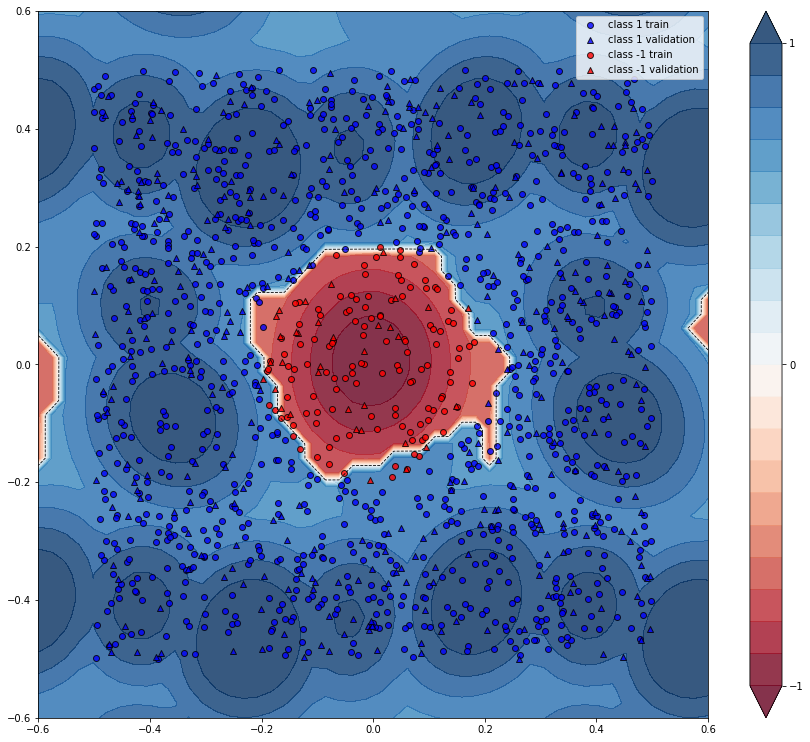

Cost: 0.1138466 | Acc train: 0.9724444 | Acc validation: 0.9600000 


In [81]:
plt.subplots(1, 1, figsize=(15, 13))
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-0.6, 0.6, 50), np.linspace(-0.6, 0.6, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
#padding = 0.3 * np.ones((len(X_grid), 1))
#X_grid = np.c_[np.c_[X_grid, padding], np.zeros((len(X_grid), 1))]  # pad each input
#normalization = np.sqrt(np.sum(X_grid ** 2, -1))
#X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array(
    [get_angles(x) for x in X_grid]
)  # angles for state preparation are new features
predictions_grid = [qc.variational_classifier(best_val, angles=f) for f in features_grid]
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data


# plot data
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    alpha=0.8,
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    alpha=0.8,
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == -1],
    X_train[:, 1][Y_train == -1],
    c="r",
    alpha=0.8,
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    alpha=0.8,
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

 # Compute predictions on train and validation set
predictions_train = [np.sign(qc.variational_classifier(best_val, angles=f)) for f in feats_train]
predictions_val = [np.sign(qc.variational_classifier(best_val, angles=f)) for f in feats_val]

# Compute accuracy on train and validation set
acc_train = accuracy(Y_train, predictions_train)
acc_val = accuracy(Y_val, predictions_val)

print(
    "Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
    "".format(qc.cost(best_val, features, Y), acc_train, acc_val)
)

1a
1b
1c
2a
2b
2c
3a
3b
3c


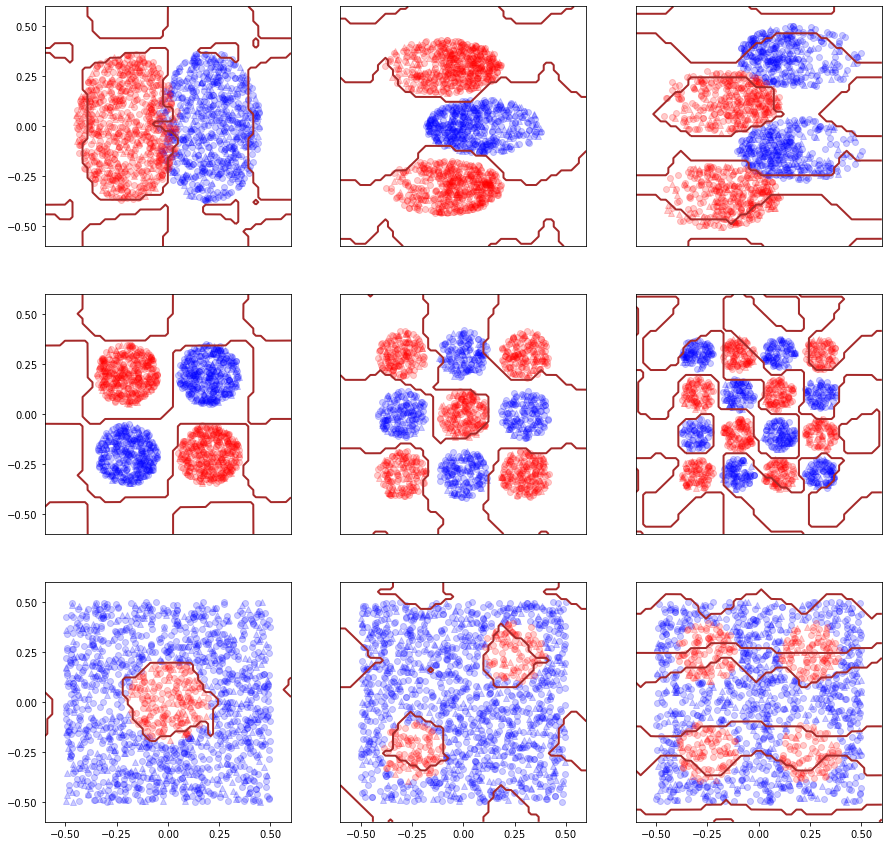

In [63]:
### PLOT ALL
######################################################################################################

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
cm = plt.cm.RdBu
ds = [eins_a,eins_b,eins_c,zwei_a,zwei_b,zwei_c,drei_a,drei_b,drei_c]

for i, ax in enumerate(axs.flat):
    
    ###############
    best_val = all_vals[i]
    
    dataset = MyCustomDataset(i)
    

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(-0.6, 0.6, 50), np.linspace(-0.6, 0.6, 50))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
    features_grid = np.array([get_angles(x) for x in X_grid])

    predictions_grid =[]

    predictions_grid = [qc.variational_classifier(best_val, angles=f) for f in features_grid]
    Z = np.reshape(predictions_grid, xx.shape)
    
    # plot decision regions
    #cnt = ax.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
    ax.contour(xx, yy, Z, levels=[0.0], colors=("brown",), linestyles=("-",), linewidths=(2,))
    

    X_train ,Y_train = dataset.get_whole()
    X_val ,Y_val = dataset.get_whole_val()

    ax.scatter(
        X_train[:, 0][Y_train == 1],
        X_train[:, 1][Y_train == 1],
        c="b",
        alpha=0.2,
        marker="o",
        label="class 1 train",
    )
    ax.scatter(
        X_val[:, 0][Y_val == 1],
        X_val[:, 1][Y_val == 1],
        c="b",
        alpha=0.2,
        marker="^",
        label="class 1 validation",
    )
    ax.scatter(
        X_train[:, 0][Y_train == 0],
        X_train[:, 1][Y_train == 0],
        c="r",
        alpha=0.2,
        marker="o",
        label="class -1 train",
    )
    ax.scatter(
        X_val[:, 0][Y_val == 0],
        X_val[:, 1][Y_val == 0],
        c="r",
        alpha=0.2,
        marker="^",
        label="class -1 validation",
    )


    
    
    custom_xlim = (-0.6, 0.6)
    custom_ylim = (-0.6, 0.6)
     # Setting the values for all axes.
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim,xticks=[],yticks=[])
    

    if i in [0,3,6]:
        plt.setp(ax,yticks=[-0.5,-0.25,0,0.25,0.5])
    if i in [6,7,8]:    
        plt.setp(ax,xticks=[-0.5,-0.25,0,0.25,0.5])

        
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(cnt, cax=cbar_ax, ticks=[-1, 0, 1])        

#plt.legend()
plt.show()



In [41]:
class TwoLayerClassic(nn.Module):
    def __init__(self):
        super(TwoLayerClassic, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.type('torch.FloatTensor')

net = TwoLayerClassic()

In [42]:
from torch.utils.data.dataset import Dataset

class MyCustomDataset(Dataset):
    
    def __init__(self,ds):
        if ds == 0:
            print('1a')
            X, Y = eins_a(1500)
        elif ds == 1:
            print('1b')
            X, Y = eins_b(1500)
        elif ds == 2:
            print('1c')
            X, Y = eins_c(1500)
        elif ds == 3:
            print('2a')
            X, Y = zwei_a(1500)
        elif ds == 4:
            print('2b')
            X, Y = zwei_b(1500)
        elif ds == 5:
            print('2c')
            X, Y = zwei_c(1500)
        elif ds == 6:
            print('3a')
            X, Y = drei_a(1500)
        elif ds == 7:
            print('3b')
            X, Y = drei_b(1500)
        elif ds == 8:
            print('3c')
            X, Y = drei_c(1500)
            
        #Y= Y * 2 - np.ones(len(Y))
        num_data = len(Y)
        num_train = int(0.75 * num_data)
        index = np.random.permutation(range(num_data))
        feats_train = features[index[:num_train]]
        Y_train = Y[index[:num_train]]
        self.dataY = Y_train
        feats_val = features[index[num_train:]]
        Y_val = Y[index[num_train:]]
        self.valY = Y_val
        # We need these later for plotting
        X_train = X[index[:num_train]]
        self.dataX = X_train
        X_val = X[index[num_train:]]
        self.valX = X_val
        
    def __getitem__(self, index):
        # stuff
        #print('u got here, pal')
        #print(inp[index][0])
        return ([self.dataX[index][0],self.dataX[index][1]], self.dataY[index])
    
    def __getvalitem__(self, index):
        # stuff
        #print('u got here, pal')
        #print(inp[index][0])
        return ([self.valX[index][0],self.valX[index][1]], self.valY[index])


    def __len__(self):
        return len(self.dataY) # of how many examples(images?) you have
    
    def __vallen__(self):
        return len(self.valY) # of how many examples(images?) you have
    
    def get_whole(self):
        return  self.dataX, self.dataY# of how many examples(images?) you have
    
    def get_whole_val(self):
        return  self.valX, self.valY# of how many examples(images?) you have

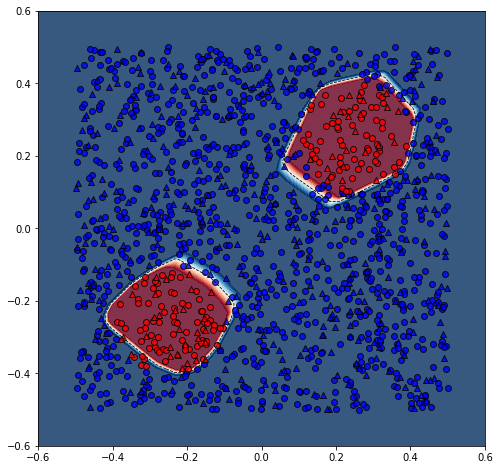

In [55]:
plt.subplots(1, 1, figsize=(15, 13))
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(-0.6, 0.6, 50), np.linspace(-0.6, 0.6, 50))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
features_grid = np.array([get_angles(x) for x in X_grid])

i=0;
predictions_grid =[]

for f in X_grid:
    
    outputs = net(torch.tensor(f).type('torch.FloatTensor'))
    ooo = outputs.detach().numpy()[0]
    predictions_grid.append(ooo)
            
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

X_train ,Y_train = dataset.get_whole()
X_val ,Y_val = dataset.get_whole_val()
    
plt.scatter(
    X_train[:, 0][Y_train == 1],
    X_train[:, 1][Y_train == 1],
    c="b",
    alpha=0.8,
    marker="o",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    alpha=0.8,
    marker="^",
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_train[:, 0][Y_train == 0],
    X_train[:, 1][Y_train == 0],
    c="r",
    alpha=0.8,
    marker="o",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 0],
    X_val[:, 1][Y_val == 0],
    c="r",
    alpha=0.8,
    marker="^",
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()


1a


<ipython-input-127-04e6cbe91d04>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lab = torch.tensor(labels).type('torch.FloatTensor')


[1,  1125] loss: 0.134
[2,  1125] loss: 0.055
[3,  1125] loss: 0.054
[4,  1125] loss: 0.053
[5,  1125] loss: 0.053
[6,  1125] loss: 0.053
[7,  1125] loss: 0.053
[8,  1125] loss: 0.053
[9,  1125] loss: 0.053
[10,  1125] loss: 0.053
[11,  1125] loss: 0.053
[12,  1125] loss: 0.053
[13,  1125] loss: 0.053
[14,  1125] loss: 0.053
[15,  1125] loss: 0.053
[16,  1125] loss: 0.053
[17,  1125] loss: 0.053
[18,  1125] loss: 0.053
[19,  1125] loss: 0.053
[20,  1125] loss: 0.053
[21,  1125] loss: 0.053
[22,  1125] loss: 0.053
[23,  1125] loss: 0.053
[24,  1125] loss: 0.053
[25,  1125] loss: 0.053
[26,  1125] loss: 0.053
[27,  1125] loss: 0.053
[28,  1125] loss: 0.052
[29,  1125] loss: 0.052
[30,  1125] loss: 0.053
[31,  1125] loss: 0.053
[32,  1125] loss: 0.052
[33,  1125] loss: 0.052
[34,  1125] loss: 0.053
[35,  1125] loss: 0.052
[36,  1125] loss: 0.053
[37,  1125] loss: 0.052
[38,  1125] loss: 0.053
[39,  1125] loss: 0.052
[40,  1125] loss: 0.052
[41,  1125] loss: 0.053
[42,  1125] loss: 0.052
[

[42,  1125] loss: 0.012
[43,  1125] loss: 0.012
[44,  1125] loss: 0.012
[45,  1125] loss: 0.012
[46,  1125] loss: 0.012
[47,  1125] loss: 0.012
[48,  1125] loss: 0.012
[49,  1125] loss: 0.012
[50,  1125] loss: 0.012
[51,  1125] loss: 0.012
[52,  1125] loss: 0.012
[53,  1125] loss: 0.012
[54,  1125] loss: 0.012
[55,  1125] loss: 0.012
[56,  1125] loss: 0.012
[57,  1125] loss: 0.012
[58,  1125] loss: 0.012
[59,  1125] loss: 0.012
[60,  1125] loss: 0.012
[61,  1125] loss: 0.012
[62,  1125] loss: 0.012
[63,  1125] loss: 0.012
[64,  1125] loss: 0.012
[65,  1125] loss: 0.012
[66,  1125] loss: 0.012
[67,  1125] loss: 0.012
[68,  1125] loss: 0.012
[69,  1125] loss: 0.012
[70,  1125] loss: 0.012
[71,  1125] loss: 0.012
[72,  1125] loss: 0.012
[73,  1125] loss: 0.012
[74,  1125] loss: 0.012
[75,  1125] loss: 0.012
[76,  1125] loss: 0.012
[77,  1125] loss: 0.012
[78,  1125] loss: 0.012
[79,  1125] loss: 0.012
[80,  1125] loss: 0.012
[81,  1125] loss: 0.012
[82,  1125] loss: 0.012
[83,  1125] loss

[82,  1125] loss: 0.008
[83,  1125] loss: 0.008
[84,  1125] loss: 0.008
[85,  1125] loss: 0.008
[86,  1125] loss: 0.008
[87,  1125] loss: 0.008
[88,  1125] loss: 0.008
[89,  1125] loss: 0.008
[90,  1125] loss: 0.008
[91,  1125] loss: 0.008
[92,  1125] loss: 0.008
[93,  1125] loss: 0.008
[94,  1125] loss: 0.008
[95,  1125] loss: 0.008
[96,  1125] loss: 0.008
[97,  1125] loss: 0.008
[98,  1125] loss: 0.008
[99,  1125] loss: 0.008
[100,  1125] loss: 0.008
Finished Training
3b
[1,  1125] loss: 0.247
[2,  1125] loss: 0.209
[3,  1125] loss: 0.177
[4,  1125] loss: 0.163
[5,  1125] loss: 0.157
[6,  1125] loss: 0.155
[7,  1125] loss: 0.153
[8,  1125] loss: 0.151
[9,  1125] loss: 0.150
[10,  1125] loss: 0.150
[11,  1125] loss: 0.148
[12,  1125] loss: 0.147
[13,  1125] loss: 0.146
[14,  1125] loss: 0.146
[15,  1125] loss: 0.146
[16,  1125] loss: 0.145
[17,  1125] loss: 0.143
[18,  1125] loss: 0.143
[19,  1125] loss: 0.142
[20,  1125] loss: 0.141
[21,  1125] loss: 0.139
[22,  1125] loss: 0.139
[23

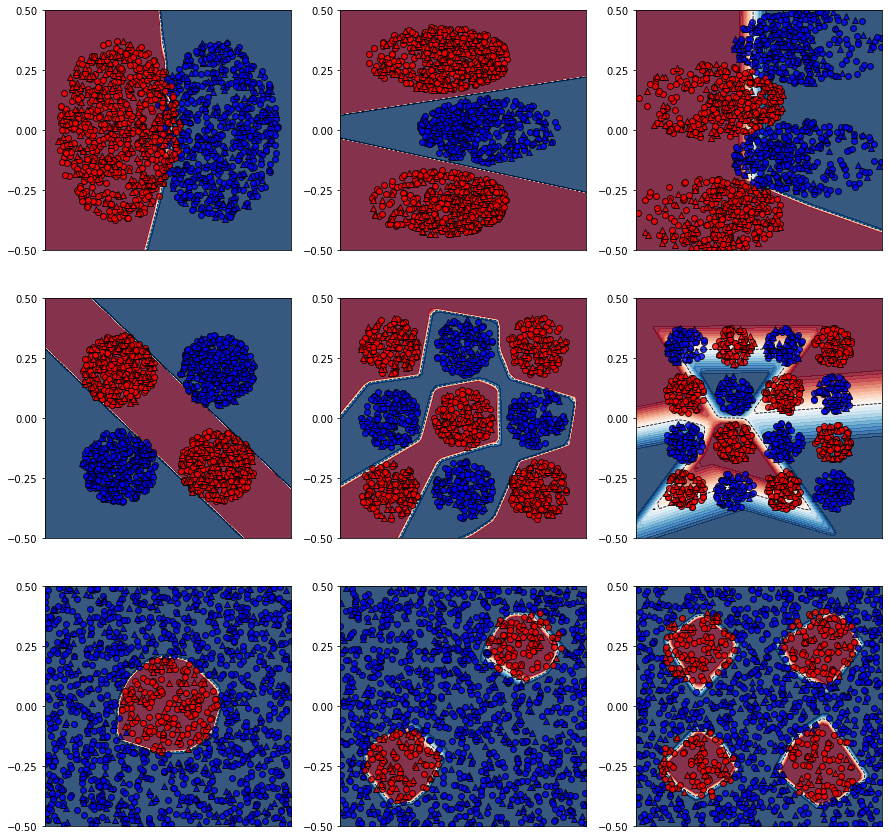

In [127]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
cm = plt.cm.RdBu
ds = [eins_a,eins_b,eins_c,zwei_a,zwei_b,zwei_c,drei_a,drei_b,drei_c]

for i, ax in enumerate(axs.flat):
    
    
    ###############
    
    net = TwoLayerClassic()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.005, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.0, amsgrad=False)
    # good: optimizer = optim.Adam(net.parameters(), lr=0.008, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.0, amsgrad=False)

    dataset = MyCustomDataset(i)

    mn_dataset_loader = torch.utils.data.DataLoader(dataset=dataset,
                                                        batch_size=1,
                                                        shuffle=False)
    r = 0

    for epoch in range(100):  # loop over the dataset multiple times

        running_loss = 0.0
        for images, labels in mn_dataset_loader:
            # Feed the data to the model
            # get the inputs; data is a list of [inputs, labels]

            # zero the parameter gradients
            optimizer.zero_grad()
            X = torch.stack(images,dim=1).type('torch.FloatTensor').to(device)
            #print(X)
            # forward + backward + optimize
            outputs = net(X)
            #print(outputs.squeeze())
            lab = torch.tensor(labels).type('torch.FloatTensor')
            #print(lab.squeeze())
            loss = criterion(outputs.squeeze(), lab.squeeze())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if r % dataset.__len__() == dataset.__len__()-1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, r + 1, running_loss / 2000))
                running_loss = 0.0
                r=0
            r+=1
    print('Finished Training')
    
    ############
    

    # make data for decision regions
    xx, yy = np.meshgrid(np.linspace(-0.6, 0.6, 50), np.linspace(-0.6, 0.6, 50))
    X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]
    features_grid = np.array([get_angles(x) for x in X_grid])

    i=0;
    predictions_grid =[]

    for f in X_grid:

        outputs = net(torch.tensor(f).type('torch.FloatTensor'))
        ooo = outputs.detach().numpy()[0]
        predictions_grid.append(ooo)

    Z = np.reshape(predictions_grid, xx.shape)
    
    # plot decision regions
    cnt = ax.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.1), cmap=cm, alpha=0.8, extend="both")
    ax.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
    

    X_train ,Y_train = dataset.get_whole()
    X_val ,Y_val = dataset.get_whole_val()

    ax.scatter(
        X_train[:, 0][Y_train == 1],
        X_train[:, 1][Y_train == 1],
        c="b",
        alpha=0.8,
        marker="o",
        edgecolors="k",
        label="class 1 train",
    )
    ax.scatter(
        X_val[:, 0][Y_val == 1],
        X_val[:, 1][Y_val == 1],
        c="b",
        alpha=0.8,
        marker="^",
        edgecolors="k",
        label="class 1 validation",
    )
    ax.scatter(
        X_train[:, 0][Y_train == 0],
        X_train[:, 1][Y_train == 0],
        c="r",
        alpha=0.8,
        marker="o",
        edgecolors="k",
        label="class -1 train",
    )
    ax.scatter(
        X_val[:, 0][Y_val == 0],
        X_val[:, 1][Y_val == 0],
        c="r",
        alpha=0.8,
        marker="^",
        edgecolors="k",
        label="class -1 validation",
    )


    
    
    custom_xlim = (-0.5, 0.5)
    custom_ylim = (-0.5, 0.5)
     # Setting the values for all axes.
    plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim,xticks=[],yticks=[])
    

    if i in [0,3,6]:
        plt.setp(ax,yticks=[-0.5,-0.25,0,0.25,0.5])
    if i in [6,7,8]:    
        plt.setp(ax,xticks=[-0.5,-0.25,0,0.25,0.5])

#plt.colorbar(cnt, ticks=[-1, 0, 1])
#plt.legend()
plt.show()
